In [ ]:
# Lazy algorithms
# - K-nearest Neighbors
# - Local Regression
# - Lazy Naive Bayes (Naive Bayes + Kernel Density Estimation (KDE))
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

# Imbalance data handling
# - Random under-sampling
# - Random over-sampling
# - NearMiss

# Domains
# - Fraud detection
# - Spam filtering
# - Disease screening
# - SaaS subscription churn
# - Advertising click-throughs

In [11]:
# Load numpy, pandas, and sklern library
# https://numpy.org/devdocs/user/absolute_beginneencoder_rs.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# from mpl_toolkits.mplot3d import Axes3D
import os
import glob
# File processing
import sys
# import scipy.spatial.distance as sc

# Distance Calculation
import math, statistics
from scipy.spatial import distance

#from chebyshev import Chebyshev
import numpy.polynomial.chebyshev 

# Data Transformation
# LabelEncoder = dummy coding
# OneHotEncoder = unique integers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, normalize
from sklearn.decomposition import PCA

# Baselines (Undersampling)
# https://imbalanced-learn.org/
# conda install -c conda-forge imbalanced-learn
# pip install -U imbalanced-learn
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import ClusterCentroids 
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import NeighbourhoodCleaningRule 
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.under_sampling import TomekLinks 
#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold # train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold # train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedKFold # train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold # train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_validate

# Performance
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import make_scorer, cohen_kappa_score

# Complexity
import time
import tracemalloc

# Multiprocessing
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if (num_cores > 20):
    num_cores -= 4
# num_cores = 24

# Warning
import warnings

# -------------------------------------------------------------------------------------
# DATA REDUCTION FUNCTION
# -------------------------------------------------------------------------------------

# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
d_name = ('Cityblock','Chebyshev','Correlation','Cosine','Euclidean')
def find_minimum_distance(d,i):
    min_dist = 999999999999999.0
    min_vec = -1
    if (d == 0): # Cityblock
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
#                new_dist = distance.cityblock(tempdata[i],tempdata[j])
                new_dist = distance.minkowski(tempdata[i],tempdata[j],1)
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
    elif (d == 1): # Chebyshev
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
                new_dist = distance.chebyshev(tempdata[i],tempdata[j])
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
    elif (d == 2): # Correlation
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
                new_dist = distance.correlation(tempdata[i],tempdata[j])
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
    elif (d == 3): # Cosine
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
                new_dist = distance.cosine(tempdata[i],tempdata[j])
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
    elif (d == 4): # Euclidean
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
#                new_dist = distance.euclidean(tempdata[i],tempdata[j]) # fast
                new_dist = distance.minkowski(tempdata[i],tempdata[j],2)
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
#    elif (d == 5): # Hamming
#        for j in range(tempdata.shape[0]):
#            if (templabel[i] != templabel[j]):
#                new_dist = distance.hamming(tempdata[i],tempdata[j])
#                if (new_dist < min_dist):
#                    min_dist = new_dist
#                    min_vec = j
#    elif (d == 5): # Mahalanobis
#        for j in range(tempdata.shape[0]):
#            if (templabel[i] != templabel[j]):
#                new_dist = distance.mahalanobis(tempdata[i],tempdata[j])
#                if (new_dist < min_dist):
#                    min_dist = new_dist
#                    min_vec = j
    elif (d == 5): # Minkowski p=3
        for j in range(tempdata.shape[0]):
            if (templabel[i] != templabel[j]):
                new_dist = distance.minkowski(tempdata[i],tempdata[j],3)
                if (new_dist < min_dist):
                    min_dist = new_dist
                    min_vec = j
                    
    return min_vec
            
# -------------------------------------------------------------------------------------
# PARAMETERS
# -------------------------------------------------------------------------------------

start_set = 0
max_level = 4
max_baseline = 14+4
max_technique = max_level+max_baseline
max_k = 5
max_distance = 1
reduction_load = 0
reduction_save = 0
encoder = 1 # label = 1, onehot = 2
pca = 1
pca_components = 0.99
normalization = 1
cross_validation = 1
cross_validation_fold = 5
parallel = 1
model = 'knn' # knn, svm
training = 1
train_ratio = 0.3
train_ratio_100k = 0.1
train_ratio_500k = 0.01
performance_save = 1
figure_save = 1
label_title = ('Accuracy','Precision','Recall','F1-Score','AUC (One-vs-Rest)','AUC (One-vs-One)','Reduction Rate','Class Balance')
# Subscript = _, Superscript = ^, use {} for multiple letters
#label_traintype = ('ORG','CNN','ENN','RENN','All KNN','TL','OSS','NCL','NM$_1$','NM$_2$','NM$_3$','IHT','CC','RUS','IBP$_1$','IBP$_2$','IBP$_3$','IBP$_4$')
label_traintype = ('ORG','CNN','ENN','RENN','All KNN','TL','OSS','NCL','NM$_1$','NM$_2$','NM$_3$','IHT','CC','RUS','DIS$_1$','IBP$_1$','DIS$_2$','IBP$_2$','DIS$_3$','IBP$_3$','DIS$_4$','IBP$_4$')

# Reset performance files(Cross Validation)
if (performance_save == 1):

    files = glob.glob('*.txt')
    for f in files:
        os.remove(f)    
    files = glob.glob('*.pdf')
    for f in files:
        os.remove(f)    
    
#    try: os.remove("class_balance.txt")
#    except OSError: pass
#    try: os.remove("class_balance_percentage.txt")
#    except OSError: pass
#    try: os.remove("reduction.txt")
#    except OSError: pass
#    try: os.remove("cross_fit_time.txt")
#    except OSError: pass
#    try: os.remove("cross_score_time.txt")
#    except OSError: pass
#    try: os.remove("cross_train_accuracy.txt")
#    except OSError: pass
#    try: os.remove("cross_train_precision.txt")
#    except OSError: pass
#    try: os.remove("cross_train_recall.txt")
#    except OSError: pass
#    try: os.remove("cross_train_f1.txt")
#    except OSError: pass
#    try: os.remove("cross_train_aucovr.txt")
#    except OSError: pass
#    try: os.remove("cross_train_aucovo.txt")
#    except OSError: pass
#    try: os.remove("cross_test_accuracy.txt")
#    except OSError: pass
#    try: os.remove("cross_test_precision.txt")
#    except OSError: pass
#    try: os.remove("cross_test_recall.txt")
#    except OSError: pass
#    try: os.remove("cross_test_f1.txt")
#    except OSError: pass
#    try: os.remove("cross_test_aucovr.txt")
#    except OSError: pass
#    try: os.remove("cross_test_aucovo.txt")
#    except OSError: pass

#    Without Cross Validation
#    try: os.remove("perf_accuracy.txt")
#    except OSError: pass
#    try: os.remove("perf_precision.txt")
#    except OSError: pass
#    try: os.remove("perf_recall.txt")
#    except OSError: pass
#    try: os.remove("perf_f1.txt")
#    except OSError: pass
#    try: os.remove("perf_kappa*.txt")
#    try: os.remove("perf_roc.txt")
#    except OSError: pass

#    try: os.remove("reduction_size.txt")
#    except OSError: pass
#    try: os.remove("time_training.txt")
#    except OSError: pass
#    try: os.remove("time_testing.txt")
#    except OSError: pass
#    try: os.remove("time_reduction.txt")
#    except OSError: pass
#    try: os.remove("mem_training_current.txt")
#    except OSError: pass
#    try: os.remove("mem_testing_current.txt")
#    except OSError: pass
#    try: os.remove("mem_training_peak.txt")
#    except OSError: pass
#    try: os.remove("mem_testing_peak.txt")
#    except OSError: pass

# -------------------------------------------------------------------------------------
# LOADING DATA SETS
# -------------------------------------------------------------------------------------

# Define the location of the dataset
# https://archive.ics.uci.edu/ml/datasets.php
# http://www.timeseriesclassification.com/dataset.php
files = []
file_header = []
file_separator = []
file_label = []
file_big = []

# # Small datasets
# https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=mvar&sort=nameUp&view=table

# SYNTHETIC DATA SETS
#pca = 0
#files.append("https://drive.piyabute.com/data/research/syntactic-square.csv"); file_header.append(None); file_separator.append("\t"); file_label.append(-1); file_big.append(0); # 6A4C
#files.append("https://drive.piyabute.com/data/research/syntactic-wave.csv"); file_header.append(None); file_separator.append("\t"); file_label.append(-1); file_big.append(0); # 6A4C
# REAL-WORLD
pca = 1
files.append("https://drive.piyabute.com/data/research/banknote_authentication.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
files.append("https://drive.piyabute.com/data/research/car.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
files.append("https://drive.piyabute.com/data/research/crowdsourced_mapping.custom.csv"); file_header.append(1); file_separator.append(","); file_label.append(0); file_big.append(0); # 6A4C
files.append("https://drive.piyabute.com/data/research/letter-recognition.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(0); file_big.append(0); # 8A5C
files.append("https://drive.piyabute.com/data/research/optdigits.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C
files.append("https://drive.piyabute.com/data/research/pendigits.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 16A2C
files.append("https://drive.piyabute.com/data/research/statlog_landsat.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 36A6C
files.append("https://drive.piyabute.com/data/research/tic-tac-toe.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
files.append("https://drive.piyabute.com/data/research/TUANDROMD.csv"); file_header.append(0); file_separator.append(","); file_label.append(-1); file_big.append(0); # 36A6C
files.append("https://drive.piyabute.com/data/research/waveform-+noise.v2.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C

# files.append("https://drive.piyabute.com/data/research/australian.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C

# Not the best one
#files.append("https://drive.piyabute.com/data/research/breast-cancer-wisconsin.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
# Slow training
##files.append("https://drive.piyabute.com/data/research/connect-4.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(1); # 6A4C
## IBP1 has only less instances of all classes than cross-validation, POOR
#files.append("https://drive.piyabute.com/data/research/glass.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
## IBP1 has only less instances of class 0 than cross-validation
#files.append("https://drive.piyabute.com/data/research/iris.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
## Class 2 is too small (2 samples)
#files.append("https://drive.piyabute.com/data/research/nursery.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
# Poor f1
#files.append("https://drive.piyabute.com/data/research/page-blocks.data.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
# Poor f1
#files.append("https://drive.piyabute.com/data/research/spambase.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
# Not the best one
#files.append("https://drive.piyabute.com/data/research/statlog_image_segment.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
#files.append("https://drive.piyabute.com/data/research/statlog_shuttle.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
##files.append("https://drive.piyabute.com/data/research/waveform.v1.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
##files.append("https://drive.piyabute.com/data/research/waveform-+noise.v1.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
#files.append("https://drive.piyabute.com/data/research/waveform.v2.data.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C

# # 100-1,000
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 4A3C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 10A2C
##files.append("https://drive.piyabute.com/data/research/breast-cancer.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C

# file_header.append = line number of the attribute names (0 = first, None = none)
# file_separator.append = separator
# file_label.append = column number of the label (0 = first, -1 = last)

# # 1,001-5,000
#1
#files.append("https://drive.piyabute.com/data/research/iris.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00624/ckd-dataset-v2.csv"); file_header.append(2); file_separator.append(","); file_label.append(0); file_big.append(0); # 6A4C
#1
#files.append("https://drive.piyabute.com/data/research/ckd-dataset-v2.csv"); file_header.append(2); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
#2
#files.append("https://drive.piyabute.com/data/research/car.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 6A4C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00404/OBS-Network-DataSet_2_Aug27.arff"); file_header.append(24); file_separator.append(","); file_label.append(-1); file_big.append(0); # 21A4C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 8A28C
##files.append("https://drive.piyabute.com/data/research/winequality-red.csv"); file_header.append(0); file_separator.append(";"); file_label.append(-1); file_big.append(0); # 11A6C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"); file_header.append(0); file_separator.append(";"); file_label.append(-1); file_big.append(0); # 11A6C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"); file_header.append(0); file_separator.append(";"); file_label.append(-1); file_big.append(0); # 11A7C

# 1,001-5,000 (high dimensions)
#3
#files.append("https://drive.piyabute.com/data/research/TUANDROMD.csv"); file_header.append(0); file_separator.append(","); file_label.append(-1); file_big.append(0); # 36A6C
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C
#4
#files.append("https://drive.piyabute.com/data/research/optdigits.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn"); file_header.append(None); file_separator.append(" "); file_label.append(-1); file_big.append(0); # 36A6C
#5
#files.append("https://drive.piyabute.com/data/research/sat.custom.csv"); file_header.append(None); file_separator.append(" "); file_label.append(-1); file_big.append(0); # 36A6C
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00622/TUANDROMD.csv"); file_header.append(0); file_separator.append(","); file_label.append(-1); file_big.append(0); # 36A6C

# 5,001-10,000
#6
#files.append("https://drive.piyabute.com/data/research/pendigits.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 16A2C
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 16A2C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00508/qsar_oral_toxicity.zip"); file_header.append(0); file_separator.append(";"); file_label.append(-1); file_big.append(0); # 1024A2C
    
# 10,001-20,000
#files.append("https://drive.piyabute.com/data/research/aps_failure_training_set.csv"); file_header.append(20); file_separator.append(","); file_label.append(0); file_big.append(0); # 16A2C
#7 Good, worse than CNN
#files.append("https://drive.piyabute.com/data/research/letter-recognition.data"); file_header.append(None); file_separator.append(","); file_label.append(0); file_big.append(0); # 8A5C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"); file_header.append(None); file_separator.append(","); file_label.append(0); file_big.append(0); # 8A5C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"); file_header.append(0); file_separator.append(","); file_label.append(-1); file_big.append(0); # 17A2C

# 20,001-30,000
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 14A2C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"); file_header.append(1); file_separator.append(","); file_label.append(-1); file_big.append(0); # 24A2C

# 30,001-40,000

# 40,001-50,000
# Poor
#files.append("https://drive.piyabute.com/data/research/nomao.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C
##files.append("https://drive.piyabute.com/data/research/default.custom.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 64A10C
##files.append("https://drive.piyabute.com/data/research/shuttle.custom.csv"); file_header.append(None); file_separator.append(" "); file_label.append(-1); file_big.append(0); # 64A10C
# Poor
##files.append("https://drive.piyabute.com/data/research/adult.csv"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 14A2C
##files.append("https://drive.piyabute.com/data/research/bank-additional-full.csv"); file_header.append(0); file_separator.append(";"); file_label.append(0); file_big.append(0); # 8A5C


# 50,001-100,000
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv"); file_header.append(0); file_separator.append(","); file_label.append(4); file_big.append(0); # 11A4C
##files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/00325/Sensorless_drive_diagnosis.txt"); file_header.append(None); file_separator.append(" "); file_label.append(-1); file_big.append(0); # 11A4C

# 100,001-300,000
#10
#files.append("https://drive.piyabute.com/data/nsl-kdd/KDDTrain+.txt"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 42A21C

# 300,001-500,000
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 41A2C

# >= 500,000
#files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); # 54A7C

# files.append(""); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0); 

# Too small class members
# files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0);
# files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0);
# files.append("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data"); file_header.append(None); file_separator.append(","); file_label.append(-1); file_big.append(0);

# Local data sets
# files.append("D:\\Documents\\Google Drive\\Data Sets\\elena-phoneme_5d_2c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-nursery_8d_5c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-poker_10d_10c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-winequality-red_12d_6c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-winequality-white_12d_7c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-adult_14d_2c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-pendigits_16d_10c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-bankmarketing_20d_2c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-defaultofcreditcardclients_23d_2c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-statloglandsat_36d_6c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-statlogshuttle_36d_7c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\elena-texture_40d_8c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-censusincome_41d_2c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-covertype_54d_7c.csv")
# files.append("D:\\Documents\\Google Drive\\Data Sets\\uci-optdigits_64d_10c.csv")
max_set = len(files)
#max_set = 2

# print("Task begins.")

#global_reduction = np.zeros((max_set,max_technique),dtype = np.float64)
#global_fit_time = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_score_time = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_accuracy = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_precision = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_recall = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_f1 = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_aucovr = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_train_aucovo = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_accuracy = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_precision = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_recall = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_f1 = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_aucovr = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#global_test_aucovo = np.zeros((max_set,max_technique,max_k),dtype = np.float64)
#max_test_accuracy = np.zeros((max_set,max_technique),dtype = np.float64)
#max_test_precision = np.zeros((max_set,max_technique),dtype = np.float64)
#max_test_recall = np.zeros((max_set,max_technique),dtype = np.float64)
#max_test_f1 = np.zeros((max_set,max_technique),dtype = np.float64)
#max_test_auc = np.zeros((max_set,max_technique),dtype = np.float64)
#max_test_auc2 = np.zeros((max_set,max_technique),dtype = np.float64)

for dataset in range(start_set,max_set):

    # Define output storage
    # perf_confusion_matrix=np.zeros(10,4,10,10)
    # perf_confusion_matrix = np.zeros((max_set,max_technique,max_k),dtype=np.float64)
    reduction = np.zeros((max_technique),dtype = np.intc)
    perf_fit_time = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_score_time = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_accuracy = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_precision = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_recall = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_f1 = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_aucovr = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_train_aucovo = np.zeros((max_technique,max_k),dtype = np.float64)
#    perf_train_accuracy_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_precision_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_recall_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_f1_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_aucovr_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_aucovo_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_train_kappa_bar_value = np.zeros((max_technique),dtype = np.float64)
    perf_test_accuracy = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_test_precision = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_test_recall = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_test_f1 = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_test_aucovr = np.zeros((max_technique,max_k),dtype = np.float64)
    perf_test_aucovo = np.zeros((max_technique,max_k),dtype = np.float64)
#    perf_test_accuracy_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_precision_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_recall_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_f1_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_aucovr_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_aucovo_bar_value = np.zeros((max_technique),dtype = np.float64)
#    perf_test_kappa_bar_value = np.zeros((max_technique),dtype = np.float64)
    reduction_bar_value = np.zeros((max_technique),dtype = np.float64)
    time_training = np.zeros((max_technique,max_k),dtype = np.float64)
    time_testing = np.zeros((max_technique,max_k),dtype = np.float64)
    time_reduction = np.zeros((max_technique),dtype = np.float64)
    mem_training_current = np.zeros((max_technique,max_k),dtype = np.float64)
    mem_testing_current = np.zeros((max_technique,max_k),dtype = np.float64)
    mem_training_peak = np.zeros((max_technique,max_k),dtype = np.float64)
    mem_testing_peak = np.zeros((max_technique,max_k),dtype = np.float64)
    k_array = np.zeros((max_k),dtype = np.intc)
    d_array = np.zeros((max_set),dtype = np.intc)
    l_array = np.zeros((max_technique),dtype = np.intc)
    l_reduction = np.zeros((max_technique),dtype = np.float64)
    
    # Load data file to DataFrame
    inputfile = files[dataset]
    print("Dataset:",dataset)
    print("Data Source:",inputfile)
    if (inputfile[-2:] == "gz"):
        df = pd.read_csv(inputfile, header = file_header[dataset], sep = file_separator[dataset], compression="gzip")
    elif (inputfile[-3:] == ".zip"):
        df = pd.read_csv(inputfile, header = file_header[dataset], sep = file_separator[dataset], compression="zip")
    elif (inputfile[-4:] == ".xls") or (inputfile[-4:] == "xlsx"):
        df = pd.read_excel(inputfile, header = file_header[dataset])      
    else:
        df = pd.read_csv(inputfile, header = file_header[dataset], sep = file_separator[dataset])

        
    # -------------------------------------------------------------------------------------
    # PANDAS DATA PRE-PROCESSING
    # -------------------------------------------------------------------------------------

    # Drop specific rows
    if (inputfile == "https://drive.piyabute.com/data/research/TUANDROMD.csv"): df.drop(df.index[2533], inplace=True)
    if (inputfile == "https://drive.piyabute.com/data/research/yeast.data"): df.drop(labels=None, axis=0, inplace=True)
   
    # Stratified sampling
    if (file_big[dataset] > 0): 
        # Generate column index
        df.columns = df.columns.map(str)
        df = df.groupby(df.columns[file_label[dataset]], group_keys=False).apply(lambda x: x.sample(file_big[dataset]))
    
    # Fill missing values (slow for big data)
    #df = df.fillna(df.mean())
    #df = df.fillna(df.median())
    #df = df.fillna(df.mode())

    # Convert dataframe to numpy
    raw = df.to_numpy()

    # -------------------------------------------------------------------------------------
    # RAW DATA PRE-PROCESSING
    # -------------------------------------------------------------------------------------

    # Categorical to Numerical
    if (encoder == 1):
        labelencoder = LabelEncoder()
        print("Preprocessing: Attribute =",df.shape[1],"[",end="")
        dflist = df.dtypes.tolist()
        for i in range(0,len(dflist)):
            if (dflist[i]=="object"):
                print(i,"E ",end="",sep="")
                raw[:,i] = labelencoder.fit_transform(raw[:,i])
            elif (i==(len(dflist)-1) and file_label[dataset]==-1):
                print(i,"E ",end="",sep="")
                raw[:,i] = labelencoder.fit_transform(raw[:,i])
            elif (i==file_label[dataset]):
                print(i,"E ",end="",sep="")
                raw[:,i] = labelencoder.fit_transform(raw[:,i])
            else:
                print(i," ",end="",sep="")
        print("] (LabelEncoding)")
    elif (encoder == 2): # Incomplete!
        print("Preprocessing: Attribute =",df.shape[1],"(",end="")
        dflist = df.dtypes.tolist()
        for i in range(0,len(dflist)-1):
            if (dflist[i]=="object"):
                print(i,"E ",end="",sep="")
                # creating instance of one-hot-encoder
                enc = OneHotEncoder(categories='all', drop=None, sparse=True, handle_unknown='ignore')
                encode_temp = enc.fit_transform(raw[:,i].reshape(-1,1)).toarray()
                raw = np.concatenate((raw, encode_temp), axis=0, out=None)
            else:
                print(i," ",end="",sep="")
        labelencoder = LabelEncoder()
        raw[:,len(dflist)-1] = labelencoder.fit_transform(raw[:,len(dflist)-1])
        print(") (OneHotEncoding)")
        
    # Extract the label attribute
    trainsetlabel = raw[:,file_label[dataset]]
    trainsetlabel = trainsetlabel.astype(int)

    # Remove the label attribute
    trainsetdata = np.delete(raw,file_label[dataset],1)

    # Calculate PCA
    if (pca == 1):
        # pca = PCA(n_components=pca_components,svd_solver="full")
        mypca = PCA(n_components=pca_components)
        traindata = mypca.fit_transform(trainsetdata)
        trainlabel = trainsetlabel
    else:
        traindata = trainsetdata
        trainlabel = trainsetlabel
    
    # Normalize normal attributes using MinMacScaler
    if (normalization == 1):
        scaler = MinMaxScaler(feature_range=(0.01, 0.99))
        scaler.fit(traindata)
        traindata = scaler.transform(traindata)
        trainlabel = trainlabel - np.amin(trainlabel)
      
    # Construct the training set and test set
    if (cross_validation == 1):
        testdata = []
        testlabel = []
        trainsize = traindata.shape[0]
        traindimension = traindata.shape[1]
        reduction[max_level] = trainsize
    else:
        if ((traindata.shape[0]*traindata.shape[1])<100000):
            traindata, testdata, trainlabel, testlabel = train_test_split(traindata, trainlabel, train_size=train_ratio, stratify=trainlabel, random_state=42)
        elif ((traindata.shape[0]*traindata.shape[1])<500000):
            traindata, testdata, trainlabel, testlabel = train_test_split(traindata, trainlabel, train_size=train_ratio_100k, stratify=trainlabel, random_state=42)
        else:
            traindata, testdata, trainlabel, testlabel = train_test_split(traindata, trainlabel, train_size=train_ratio_500k, stratify=trainlabel, random_state=42)
        trainsize = traindata.shape[0]
        traindimension = traindata.shape[1]
        testsize = testdata.shape[0]
        testdimension = testdata.shape[1]
        reduction[max_level] = trainsize     

    print("Preprocessing: Attribute =",traindimension,"(PCA)" if pca==1 else "(Non-PCA)","(Norm)" if normalization==1 else "(Non-Norm)")
    print("Preprocessing: Sample    =",trainsize)
    print("Preprocessing: Class     =", len(np.unique(trainlabel)), np.unique(trainlabel))
    reduction_class = np.zeros((max_technique,len(np.unique(trainlabel))),dtype = np.float64)

    # Print class balance
    unique_train, counts_train = np.unique(trainlabel, return_counts=True)
    print("Preprocessing: Train     =",dict(zip(unique_train, counts_train)))
    if (cross_validation == 0):
        unique_test, counts_test = np.unique(testlabel, return_counts=True)
        print("Preprocessing: Test      =",dict(zip(unique_test, counts_test)))

    # Plot original data
#    if (figure_save == 1):
#        if (traindimension == 2):
#            scatter_x = traindata[:,0]
#            scatter_y = traindata[:,1]
#            scatter_x_min = min(scatter_x)
#            scatter_x_max = max(scatter_x)
#            scatter_y_min = min(scatter_y)
#            scatter_y_max = max(scatter_y)
#            group = trainlabel

#            fig, ax = plt.subplots()
#            for g in np.unique(group):
#                ix = np.where(group == g)
#                ax.scatter(scatter_x[ix], scatter_y[ix], label = g, s = 1, alpha=0.5)
##            ax.legend(loc='upper left')
#            plt.xlim([scatter_x_min,scatter_x_max])
#            plt.ylim([scatter_y_min,scatter_y_max])
#            plt.xlabel('X')
#            plt.ylabel('Y')
##            plt.savefig(os.path.basename(inputfile)+"-org.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None)
#            plt.savefig("instance-"+str(dataset+1).zfill(2)+"-org.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#            plt.show()

#        if (traindimension == 3):
#            scatter_x = traindata[:,0]
#            scatter_y = traindata[:,1]
#            scatter_z = traindata[:,2]
#            scatter_x_min = min(scatter_x)
#            scatter_x_max = max(scatter_x)
#            scatter_y_min = min(scatter_y)
#            scatter_y_max = max(scatter_y)
#            scatter_z_min = min(scatter_z)
#            scatter_z_max = max(scatter_z)
#            group = trainlabel

#            fig = plt.figure()
#            ax = fig.add_subplot(projection="3d")
#            for g in np.unique(group):
#                ix = np.where(group == g)
#                ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], label = g, s = 1, alpha=0.5)
##            ax.legend(loc='upper left')
#            plt.xlim([scatter_x_min,scatter_x_max])
#            plt.ylim([scatter_y_min,scatter_y_max])
#            plt.zlim([scatter_z_min,scatter_z_max])
#            plt.xlabel('X')
#            plt.ylabel('Y')
#            plt.zlabel('Z')
##            ax.set_zlim([scatter_z_min,scatter_z_max])
##            plt.savefig(os.path.basename(inputfile)+"-org.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None)
#            plt.savefig("instance-"+str(dataset+1).zfill(2)+"-org.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#            plt.show()

#    for d in range(0,max_distance):
    for d in range(4,5):

        # -------------------------------------------------------------------------------------
        # MY DATA REDUCTION
        # -------------------------------------------------------------------------------------

        print("Reduction begins...")
        tempset = raw
        tempdata = traindata
        templabel = trainlabel
        scatter_x = []
        scatter_y = []

        for level in range(0,max_level):

            time_start = time.perf_counter()

            # Parallel or serialized reduction
            if (parallel == 1):
                if __name__ == "__main__":
                    ProcessList = Parallel(n_jobs=num_cores)(delayed(find_minimum_distance)(d,i) for i in range(tempdata.shape[0]))
            else:
                ProcessList = [0]*tempdata.shape[0]
                for i in range(0,tempdata.shape[0]):
                    ProcessList[i] = find_minimum_distance(i)
                    print(i,templabel[i],ProcessList[i],templabel[ProcessList[i]])
            trainvectormin = np.unique(ProcessList)
            traindataunique = tempdata[trainvectormin]
            trainlabelunique = templabel[trainvectormin]

            # Remove duplication
            time_stop = time.perf_counter()
            
            print(max_baseline-max_level+level*2)
            print(max_baseline-max_level+level*2+1)
            time_reduction[max_baseline-max_level+level*2] = time_stop - time_start
            time_reduction[max_baseline-max_level+level*2+1] = time_stop - time_start

            if level == 0:
                traindataunique1 = traindataunique
                trainlabelunique1 = trainlabelunique
                tempsetbefore = tempdata.shape[0]
                tempdata1 = np.delete(tempdata,trainvectormin,0)
                templabel1 = np.delete(templabel,trainvectormin,0)

#                # Maintain minimum values for n-fold cross-validation
#                unique_templabel, counts_templabel = np.unique(templabel1, return_counts=True)
#                mydict = dict(zip(unique_templabel,counts_templabel))
#                for i in mydict: 
#                    mydict[i]=np.maximum(mydict[i],cross_validation_fold*max_k*2)
#                mymodel = SMOTE(n_jobs=-1,sampling_strategy=mydict)
#                tempdata, templabel = mymodel.fit_resample(tempdata1, templabel1)
#                tempsetafter = tempdata.shape[0]

                tempdata = tempdata1
                templabel = templabel1
                tempsetafter = tempdata1.shape[0]
            elif level == 1:
                traindataunique2 = traindataunique
                trainlabelunique2 = trainlabelunique
                tempsetbefore = tempdata.shape[0]
                tempdata2 = np.delete(tempdata,trainvectormin,0)
                templabel2 = np.delete(templabel,trainvectormin,0)

#                # Maintain minimum values for n-fold cross-validation
#                unique_templabel, counts_templabel = np.unique(templabel2, return_counts=True)
#                mydict = dict(zip(unique_templabel,counts_templabel))IBP
#                for i in mydict: 
#                    mydict[i]=np.maximum(mydict[i],cross_validation_fold*max_k*2)
#                mymodel = SMOTE(n_jobs=-1,sampling_strategy=mydict)
#                tempdata, templabel = mymodel.fit_resample(tempdata2, templabel2)
#                tempsetafter = tempdata.shape[0]

                tempdata = tempdata2
                templabel = templabel2
                tempsetafter = tempdata2.shape[0]
            elif level == 2:
                traindataunique3 = traindataunique
                trainlabelunique3 = trainlabelunique
                tempsetbefore = tempdata.shape[0]
                tempdata3 = np.delete(tempdata,trainvectormin,0)
                templabel3 = np.delete(templabel,trainvectormin,0)

#                # Maintain minimum values for n-fold cross-validation
#                unique_templabel, counts_templabel = np.unique(templabel3, return_counts=True)
#                mydict = dict(zip(unique_templabel,counts_templabel))
#                for i in mydict: 
#                    mydict[i]=np.maximum(mydict[i],cross_validation_fold*max_k*2)
#                mymodel = SMOTE(n_jobs=-1,sampling_strategy=mydict)
#                tempdata, templabel = mymodel.fit_resample(tempdata3, templabel3)
#                tempsetafter = tempdata.shape[0]

                tempdata = tempdata3
                templabel = templabel3
                tempsetafter = tempdata3.shape[0]
            elif level == 3:
                traindataunique4 = traindataunique
                trainlabelunique4 = trainlabelunique
                tempsetbefore = tempdata.shape[0]
                tempdata4 = np.delete(tempdata,trainvectormin,0)
                templabel4 = np.delete(templabel,trainvectormin,0)

#                # Maintain minimum values for n-fold cross-validation
#                unique_templabel, counts_templabel = np.unique(templabel4, return_counts=True)
#                mydict = dict(zip(unique_templabel,counts_templabel))
#                for i in mydict: 
#                    mydict[i]=np.maximum(mydict[i],cross_validation_fold*max_k*2)
#                mymodel = SMOTE(n_jobs=-1,sampling_strategy=mydict)
#                tempdata, templabel = mymodel.fit_resample(tempdata4, templabel4)
#                tempsetafter = tempdata.shape[0]

                tempdata = tempdata4
                templabel = templabel4
                tempsetafter = tempdata4.shape[0]

            print("Reduction: Level ",level+1," is constructed. / Time = ","{:0.2f}".format(time_stop - time_start)," seconds / Size = ",traindataunique.shape[0]," / Original = ",tempsetbefore," / Remain = ", tempsetafter, sep = "")

            # Save reduced data sets
            if (reduction_save == 1):
                if (pca == 1):
                    outputfile = inputfile[:-4]+"_pca_"+str(level+1)+".csv"
                else:
                    outputfile = inputfile[:-4]+"_"+str(level+1)+".csv"
                with open(outputfile, "ab") as file:
                    if (level == 0):
                        np.savetxt(file, np.c_[traindataunique1, np.array(trainlabelunique1)], delimiter=",", fmt="%1.4f")            
                    elif (level == 1):
                        np.savetxt(file, np.c_[traindataunique2, np.array(trainlabelunique2)], delimiter=",", fmt="%1.4f")            
                    elif (level == 2):
                        np.savetxt(file, np.c_[traindataunique3, np.array(trainlabelunique3)], delimiter=",", fmt="%1.4f")            
                    elif (level == 3):
                        np.savetxt(file, np.c_[traindataunique4, np.array(trainlabelunique4)], delimiter=",", fmt="%1.4f")            
                    print("Saving level "+str(level+1)+" to "+outputfile, sep=" ")
                       
        # -------------------------------------------------------------------------------------
        # Training Set Construction
        # -------------------------------------------------------------------------------------

        # https://imbalanced-learn.org/
        print("Training:")
        for traintype in range(0,max_technique):
            if traintype == 0:
                xready = traindata
                tready = trainlabel
                temp, reduction_class_org = np.unique(tready, return_counts=True)
            elif traintype < 14:
                time_start = time.perf_counter()
                if traintype == 1:
                    mymodel = CondensedNearestNeighbour(n_jobs=-1,sampling_strategy='all')
                elif traintype == 2:
                    mymodel = EditedNearestNeighbours(n_jobs=-1,sampling_strategy='all',kind_sel='mode')
                elif traintype == 3:
                    mymodel = RepeatedEditedNearestNeighbours(n_jobs=-1,sampling_strategy='all',kind_sel='mode')
                elif traintype == 4:
                    mymodel = AllKNN(n_jobs=-1,sampling_strategy='all',kind_sel='mode')
                elif traintype == 5:
                    mymodel = TomekLinks(n_jobs=-1,sampling_strategy='all')
                elif traintype == 6:
                    mymodel = OneSidedSelection(n_jobs=-1,sampling_strategy='all')
                elif traintype == 7:
                    mymodel = NeighbourhoodCleaningRule(n_jobs=-1,sampling_strategy='all',kind_sel='mode')
                elif traintype == 8:
                    mymodel = NearMiss(n_jobs=-1,sampling_strategy='all',version=1)
                elif traintype == 9:
                    mymodel = NearMiss(n_jobs=-1,sampling_strategy='all',version=2)
                elif traintype == 10:
                    mymodel = NearMiss(n_jobs=-1,sampling_strategy='all',version=3)
                elif traintype == 11:
                    mymodel = InstanceHardnessThreshold(n_jobs=-1,sampling_strategy='all')
                elif traintype == 12:
                    mymodel = ClusterCentroids(n_jobs=-1,sampling_strategy='all',voting='auto')
                elif traintype == 13:
                    mymodel = RandomUnderSampler(sampling_strategy='all',replacement=True)
                 
                xready, tready = mymodel.fit_resample(traindata, trainlabel)
                time_stop = time.perf_counter()
                time_reduction[traintype] = time_stop - time_start
            else: # SMOTE
                if traintype == 14 or traintype == 15:
                    xready = traindataunique1
                    tready = trainlabelunique1
                elif traintype == 16 or traintype == 17:
                    xready = np.vstack((traindataunique1,traindataunique2))
                    tready = np.hstack((trainlabelunique1,trainlabelunique2))
                elif traintype == 18 or traintype == 19:
                    xready = np.vstack((traindataunique1,traindataunique2,traindataunique3))
                    tready = np.hstack((trainlabelunique1,trainlabelunique2,trainlabelunique3))
                elif traintype == 20 or traintype == 21:
                    xready = np.vstack((traindataunique1,traindataunique2,traindataunique3,traindataunique4))
                    tready = np.hstack((trainlabelunique1,trainlabelunique2,trainlabelunique3,trainlabelunique4))

            unique_tready, counts_tready = np.unique(tready, return_counts=True)
#            print("Training: Type ",traintype," ",label_traintype[traintype],"; set=",dataset,"; sample=", len(tready)," ({:0.2f}".format(len(tready)/len(trainlabel)*100), "%) ", dict(zip(unique_tready, counts_tready)), sep = "");

            # OverSampling IBP
            if traintype == 15 or traintype == 17 or traintype == 19 or traintype == 21:
#            if traintype > 0:
                # Maintain minimum values for n-fold cross-validation
                time_start = time.perf_counter()

                unique_tready, counts_tready = np.unique(tready, return_counts=True)
                mydict = dict(zip(unique_tready,counts_tready))
                print("Training: (Pre) Type ",traintype," ",label_traintype[traintype],"; set=",dataset,"; sample=", len(tready)," ({:0.2f}".format(len(tready)/len(trainlabel)*100), "%) ", dict(zip(unique_tready, counts_tready)), sep = "");
                for i in mydict: 
                    mydict[i]=np.maximum(mydict[i],cross_validation_fold*max_k*4)

#                mymodel_smote = SMOTE(n_jobs=-1,sampling_strategy=mydict)
                mymodel_ros = RandomOverSampler(sampling_strategy=mydict)
                xready, tready = mymodel_ros.fit_resample(xready, tready)
                unique_tready, counts_tready = np.unique(tready, return_counts=True)

                time_stop = time.perf_counter()
                print("Before: ",time_reduction[traintype])
                time_reduction[traintype] = time_reduction[traintype] + time_stop - time_start
                print("After: ",time_reduction[traintype])

            print("Training: (Post) Type ",traintype," ",label_traintype[traintype],"; set=",dataset,"; sample=", len(tready)," ({:0.2f}".format(len(tready)/len(trainlabel)*100), "%) ", dict(zip(unique_tready, counts_tready)), sep = "");

            if (len(np.unique(tready))<len(np.unique(trainlabel))):
                print("Training: Cannot maintain all class labels!")
#                continue

            reduction[traintype] = len(tready)

            # Fixing empty class
            j = 0;
            for i in unique_tready:
                reduction_class[traintype][i] = counts_tready[j]
                j += 1

            # Plot training sets
            if (figure_save == 1):
                colors = ['g','b','r','m'];
                if (traindimension == 2):
                    scatter_x = xready[:,0]
                    scatter_y = xready[:,1]
#                    scatter_x_min = min(scatter_x)
#                    scatter_x_max = max(max(scatter_x),1)
#                    scatter_y_min = min(scatter_y)
#                    scatter_y_max = max(max(scatter_y),1)
                    scatter_x_min = 0
                    scatter_x_max = 1
                    scatter_y_min = 0
                    scatter_y_max = 1
                    group = tready
                    plt.scatter(scatter_x, scatter_y, c=tready, cmap=matplotlib.colors.ListedColormap(colors), s = 1, alpha=0.5);
                    plt.xlim([scatter_x_min,scatter_x_max])
                    plt.ylim([scatter_y_min,scatter_y_max])
                    plt.title(label_traintype[traintype],fontsize=30,fontweight='bold')
                    plt.xlabel('X')
                    plt.ylabel('Y')
                    plt.savefig("instance-"+str(dataset+1).zfill(2)+"-"+str(traintype+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
                    plt.show()
                    plt.close()

                if (traindimension == 3):
                    scatter_x = xready[:,0]
                    scatter_y = xready[:,1]
                    scatter_z = xready[:,2]
#                    scatter_x_min = min(scatter_x)
#                    scatter_x_max = max(max(scatter_x),1)
#                    scatter_y_min = min(scatter_y)
#                    scatter_y_max = max(max(scatter_y),1)
#                    scatter_z_min = min(scatter_z)
#                    scatter_z_max = max(max(scatter_z),1)
                    scatter_x_min = 0
                    scatter_x_max = 1
                    scatter_y_min = 0
                    scatter_y_max = 1
                    scatter_z_min = 0
                    scatter_z_max = 1
                    group = tready
                    plt.scatter(scatter_x, scatter_y, scatter_z, c=tready, cmap=matplotlib.colors.ListedColormap(colors), s = 1, alpha=0.5);
                    plt.title(label_traintype[traintype],fontsize=30,fontweight='bold')
                    plt.xlim([scatter_x_min,scatter_x_max])
                    plt.ylim([scatter_y_min,scatter_y_max])
                    plt.zlim([scatter_z_min,scatter_z_max])
                    plt.xlabel('X')
                    plt.ylabel('Y')
                    plt.zlabel('Z')
                    plt.savefig("instance-"+str(dataset+1).zfill(2)+"-"+str(traintype+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
                    plt.show()
                    plt.close()

            # -------------------------------------------------------------------------------------
            # LAZY LEARNING ALGORITHMS
            # -------------------------------------------------------------------------------------

            # k-Nearest Neighbors
            # https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
            # https://scikit-learn.org/stable/modules/model_evaluation.html
            # Local Regression
            # Lazy naive Bayes
            # SVM RBF

            # Execute loop only once for non-knn
            if (model != 'knn'): max_k = 0

            for k in range(0,max_k,1):

                # Training Cross validation
                # https://towardsdatascience.com/cross-validation-using-knn-6babb6e619c8
                # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
                # https://scikit-learn.org/stable/modules/cross_validation.html
                # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
                # https://scikit-learn.org/stable/modules/model_evaluation.html
                tracemalloc.start()
                time_start = time.perf_counter()
                if (model == 'knn'):
                    clf = KNeighborsClassifier(n_neighbors=(2*k)+1,n_jobs=-1)
                elif (model == 'svm'):
                    clf = svm.SVC(kernel='linear', C=1, random_state=0,probability=True)

                if (min(counts_tready)>cross_validation_fold):
                    cross_validation_fold_final = cross_validation_fold
                elif (min(counts_tready)>2):
                    cross_validation_fold_final = min(counts_tready)
                else:
                    cross_validation_fold_final = 2

                # Early break if class members are less than k
                # if (min(counts_tready)/cross_validation_fold_final<k+1): break

                # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
                # https://sciksit-learn.org/stable/modules/model_evaluation.html
                # scores = cross_val_score(clf, xready, tready, cv=cross_validation_fold)
                scoring = {"accuracy":"accuracy",
                           "precision":"precision_weighted",
                           "recall":"recall_weighted",
                           "f1":"f1_weighted",
                           "aucovr":"roc_auc_ovr_weighted",
                           "aucovo":"roc_auc_ovo_weighted"}
                skf = StratifiedKFold(n_splits=cross_validation_fold_final, random_state=0, shuffle=True)
#                skf = KFold(n_splits=cross_validation_fold_final, random_state=0, shuffle=True)
                scores = cross_validate(clf, xready, tready, scoring=scoring, cv=skf, return_train_score=True, n_jobs=-1)

                time_stop = time.perf_counter()
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                mem_training_current[traintype,k] = current
                mem_training_peak[traintype,k] = peak
                time_training[traintype,k] = time_stop - time_start

#                global_fit_time[dataset,traintype,k] = 
                perf_fit_time[traintype,k] = statistics.mean(scores["fit_time"])
#                global_score_time[dataset,traintype,k] = 
                perf_score_time[traintype,k] = statistics.mean(scores["score_time"])
#                global_train_accuracy[dataset,traintype,k] = 
                perf_train_accuracy[traintype,k] = statistics.mean(scores["train_accuracy"])
#                global_train_precision[dataset,traintype,k] = 
                perf_train_precision[traintype,k] = statistics.mean(scores["train_precision"])
#                global_train_recall[dataset,traintype,k] = 
                perf_train_recall[traintype,k] = statistics.mean(scores["train_recall"])
#                global_train_f1[dataset,traintype,k] = 
                perf_train_f1[traintype,k] = statistics.mean(scores["train_f1"])
#                global_train_aucovr[dataset,traintype,k] = 
                perf_train_aucovr[traintype,k] = statistics.mean(scores["train_aucovr"])
#                global_train_aucovo[dataset,traintype,k] = 
                perf_train_aucovo[traintype,k] = statistics.mean(scores["train_aucovo"])
#                global_train_kappa[dataset,traintype,k] = 
#                perf_train_kappa[traintype,k] = statistics.mean(scores["train_kappa"])
#                global_test_accuracy[dataset,traintype,k] = 
                perf_test_accuracy[traintype,k] = statistics.mean(scores["test_accuracy"])
#                global_test_precision[dataset,traintype,k] = 
                perf_test_precision[traintype,k] = statistics.mean(scores["test_precision"])
#                global_test_recall[dataset,traintype,k] = 
                perf_test_recall[traintype,k] = statistics.mean(scores["test_recall"])
#                global_test_f1[dataset,traintype,k] = 
                perf_test_f1[traintype,k] = statistics.mean(scores["test_f1"])
#                global_test_aucovr[dataset,traintype,k] = 
                perf_test_aucovr[traintype,k] = statistics.mean(scores["test_aucovr"])
#                global_test_aucovo[dataset,traintype,k] = 
                perf_test_aucovo[traintype,k] = statistics.mean(scores["test_aucovo"])

                if (model == 'knn2'):
                    print("Training: Type ",label_traintype[traintype],
#                          "; MEM=","{:5.0f}".format(mem_training_current[k]/1000000),"{:5.0f}".format(mem_training_peak[k]/1000000),                     
                          "; cv=",cross_validation_fold_final,
                          "; d=",d,
                          "; k=",(2*k)+1,
                          "; Train=",reduction[traintype],
                          "; Acc=","{:0.2f}".format(perf_test_accuracy[traintype,k]),
                          "; Pre=","{:0.2f}".format(perf_test_precision[traintype,k]),
                          "; Recall=","{:0.2f}".format(perf_test_recall[traintype,k]),
                          "; F1=","{:0.2f}".format(perf_test_f1[traintype,k]),
                          "; AUC OVR=","{:0.2f}".format(perf_test_aucovr[traintype,k]),
                          "; AUC OVO=","{:0.2f}".format(perf_test_aucovo[traintype,k]),sep = "")
                elif (model == 'svm2'):
                    print("Training: Type ",label_traintype[traintype],
#                                   "; MEM=","{:5.0f}".format(mem_training_current[k]/1000000),"{:5.0f}".format(mem_training_peak[k]/1000000),                     
                          "; cv=",cross_validation_fold_final,
                          "; d=",d,
                          "; Train=",reduction[traintype],
                          "; Acc=","{:0.2f}".format(sum(perf_test_accuracy[traintype])/len(perf_test_accuracy[traintype])),
                          "; Pre=","{:0.2f}".format(sum(perf_test_precision[traintype]/len(perf_test_precision[traintype]))),
                          "; Recall=","{:0.2f}".format(sum(perf_test_recall[traintype]/len(perf_test_recall[traintype]))),
                          "; F1=","{:0.2f}".format(sum(perf_test_f1[traintype]/len(perf_test_f1[traintype]))),
                          "; AUC OVR=","{:0.2f}".format(sum(perf_test_aucovr[traintype]/len(perf_test_aucovr[traintype]))),
                          "; AUC OVO=","{:0.2f}".format(sum(perf_test_aucovo[traintype]/len(perf_test_aucovo[traintype]))), sep = "")

            # Save every train type
            if (performance_save == 1):
                with open("cross_fit_time.txt", "ab") as file:
                    np.savetxt(file, perf_fit_time[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.8f")
                with open("cross_score_time.txt", "ab") as file:
                    np.savetxt(file, perf_score_time[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.8f")
                with open("cross_train_accuracy.txt", "ab") as file:
                    np.savetxt(file, perf_train_accuracy[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")
                with open("cross_train_precision.txt", "ab") as file:
                    np.savetxt(file, perf_train_precision[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_train_recall.txt", "ab") as file:
                    np.savetxt(file, perf_train_recall[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_train_f1.txt", "ab") as file:
                    np.savetxt(file, perf_train_f1[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_train_aucovr.txt", "ab") as file:
                    np.savetxt(file, perf_train_aucovr[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_train_aucovo.txt", "ab") as file:
                    np.savetxt(file, perf_train_aucovo[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_test_accuracy.txt", "ab") as file:
                    np.savetxt(file, perf_test_accuracy[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")
                with open("cross_test_precision.txt", "ab") as file:
                    np.savetxt(file, perf_test_precision[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_test_recall.txt", "ab") as file:
                    np.savetxt(file, perf_test_recall[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_test_f1.txt", "ab") as file:
                    np.savetxt(file, perf_test_f1[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_test_aucovr.txt", "ab") as file:
                    np.savetxt(file, perf_test_aucovr[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("cross_test_aucovo.txt", "ab") as file:
                    np.savetxt(file, perf_test_aucovo[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("time_training.txt", "ab") as file:
                    np.savetxt(file, time_training[traintype].reshape(1,max_k), delimiter="\t", fmt="%1.4f")        
                with open("mem_training_current.txt", "ab") as file:
                    np.savetxt(file, mem_training_current[traintype].reshape(1,max_k), delimiter="\t", fmt="%0.0f")        
                with open("mem_training_peak.txt", "ab") as file:
                    np.savetxt(file, mem_training_peak[traintype].reshape(1,max_k), delimiter="\t", fmt="%0.0f")        

            # Print average scores
            if (model == 'knn'):
                print("Training: Type ",label_traintype[traintype],
#                      "; MEM=","{:5.0f}".format(mem_training_current[k]/1000000),"{:5.0f}".format(mem_training_peak[k]/1000000),                     
                      "; cv=",cross_validation_fold_final,
                      "; d=",d,
                      "; k=[1-",(2*k)+1,"]",
                      "; Train=",reduction[traintype],
                      "; Acc=","{:0.2f}".format(np.mean(perf_test_accuracy[traintype],axis=0)),
                      "; Pre=","{:0.2f}".format(np.mean(perf_test_precision[traintype],axis=0)),
                      "; Recall=","{:0.2f}".format(np.mean(perf_test_recall[traintype],axis=0)),
                      "; F1=","{:0.2f}".format(np.mean(perf_test_f1[traintype],axis=0)),
                      "; AUC OVR=","{:0.2f}".format(np.mean(perf_test_aucovr[traintype],axis=0)),
                      "; AUC OVO=","{:0.2f}".format(np.mean(perf_test_aucovo[traintype],axis=0)),sep = "")
            elif (model == 'svm'):
                print("Training: Type ",label_traintype[traintype],
#                      "; MEM=","{:5.0f}".format(mem_training_current[k]/1000000),"{:5.0f}".format(mem_training_peak[k]/1000000),                     
                      "; cv=",cross_validation_fold_final,
                      "; d=",d,
                      "; Train=",reduction[traintype],
                      "; Acc=","{:0.2f}".format(np.mean(perf_test_accuracy[traintype],axis=0)),
                      "; Pre=","{:0.2f}".format(np.mean(perf_test_precision[traintype],axis=0)),
                      "; Recall=","{:0.2f}".format(np.mean(perf_test_recall[traintype],axis=0)),
                      "; F1=","{:0.2f}".format(np.mean(perf_test_f1[traintype],axis=0)),
                      "; AUC OVR=","{:0.2f}".format(np.mean(perf_test_aucovr[traintype],axis=0)),
                      "; AUC OVO=","{:0.2f}".format(np.mean(perf_test_aucovo[traintype],axis=0)),sep = "")
            print()

        # Save every data set
        if (performance_save == 1):
            with open("class_balance.txt", "ab") as file:
                np.savetxt(file, counts_train.reshape(1,counts_train.shape[0]), delimiter="\t", fmt="%0.0f")
            with open("class_balance_percentage.txt", "ab") as file:
                np.savetxt(file, (counts_train/traindata.shape[0]).reshape(1,counts_train.shape[0]), delimiter="\t", fmt="%0.4f")
            with open("reduction_size.txt", "ab") as file:
                np.savetxt(file, reduction.reshape(1,reduction.shape[0]), delimiter="\t", fmt="%0.0f")
            with open("reduction_class.txt", "ab") as file:
#                np.savetxt(file, reduction_class.reshape(len(reduction_class),reduction.shape[0]), delimiter="\t", fmt="%0.0f")
                np.savetxt(file, np.transpose(reduction_class), delimiter="\t", fmt="%0.0f")
            with open("time_reduction.txt", "ab") as file:
                np.savetxt(file, time_reduction.reshape(1,max_technique), delimiter="\t", fmt="%1.4f")        

        # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylabel.html
        # https://matplotlib.org/stable/tutorials/introductory/customizing.html
        # https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams

#        # Global pyplot parameters
#        plot_alpha = 0.9
#        plot_linewidth = 1
#        plot_width = 0.5
#        plot_barlsh = 0.2
#        plt.rcParams.update({'font.family':'cmr10'})
#        plt.rcParams['font.size'] = '12'
#        # https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html
#        plt.rcParams["image.cmap"] = 'tab20b'
#        plt.rcParams["scatter.edgecolors"] = 'face'
        
#        # Plot reduction rate
#        plt.figure(figsize=(14, 2.5))
#        plt.title('Reduction Rate of the Data Set '+str(dataset+1),fontsize=20,fontweight='bold')
#        plt.ylabel('Performance (Larger is better)')
#        plt.xticks(range(0,max_technique),label_traintype)
#        plt.xlabel('Technique')
#        plt.ylim([0,1.09])
#        plt.grid(color='grey', linewidth=1, axis='both', alpha=0.2)
#        for x in range(0,max_technique):
#            plt.bar(x,1-reduction[x]/reduction[0],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#            plt.text(x-plot_barlsh,1-reduction[x]/reduction[0]+0.01,"{:.2f}".format(1-reduction[x]/reduction[0],2))
#        plt.savefig("reduction-"+str(dataset+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#        plt.close()
        
#        # Plot class balances
#        plt.figure(figsize=(14, 2.5))
#        plt.title('Class-Level Reduction Rate of the Data Set '+str(dataset+1),fontsize=20,fontweight='bold')
#        plt.ylabel('Reduction Rate (Larger is better)')
#        plt.xticks(range(0,max_technique),label_traintype)
#        plt.xlabel('Technique')
#        plt.ylim([-0.09,1.09])
#        plt.grid(color='grey', linewidth=1, axis='both', alpha=0.2)
#        for c in range(0,len(reduction_class[0])): # classes
#            plt.scatter(range(0,len(reduction_class)),1-np.transpose(reduction_class)[c]/np.transpose(reduction_class)[c][0],label=label_traintype[0],marker='.',linewidth=plot_linewidth,alpha=plot_alpha)#,label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#        plt.savefig("reduction-class-"+str(dataset+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#        plt.close()
        
#        # Plot execution time
#        plt.figure(figsize=(14, 2.5))
#        plt.title('Execution Time of the Reduction Process of the Data Set '+str(dataset+1)+" (seconds)",fontsize=20,fontweight='bold')
#        plt.ylabel('Execution Time (Smaller is better)')
#        plt.xticks(range(0,max_technique),label_traintype)
#        plt.xlabel('Technique')
#        max_time_reduction = np.max(time_reduction)+time_reduction[13]+time_reduction[14]
#        if (max_time_reduction < 10):
#            plot_barlsh_exec = plot_barlsh
#        elif (max_time_reduction < 100):
#            plot_barlsh_exec = plot_barlsh + 0.7
#        elif (max_time_reduction < 1000):
#            plot_barlsh_exec = plot_barlsh + 0.13
#        elif (max_time_reduction < 10000):
#            plot_barlsh_exec = plot_barlsh + 0.19
#        else:
#            plot_barlsh_exec = plot_barlsh + 0.25
#        max_ylim = (np.max(time_reduction)+time_reduction[13]+time_reduction[14])*1.10
#        plt.ylim([0,max_ylim])
#        plt.grid(color='grey', linewidth=1, axis='both', alpha=0.2)
#        for x in range(0,max_technique):
#            if (x == max_technique-3): # IBP1+IBP2
#                plt.bar(x,time_reduction[x]+time_reduction[x-1],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                plt.text(x-plot_barlsh_exec,time_reduction[x]+time_reduction[x-1],"{:.2f}".format(time_reduction[x]+time_reduction[x-1],2))
#            elif (x == max_technique-2): # IBP1+IBP2+IBP3
#                plt.bar(x,time_reduction[x]+time_reduction[x-1]+time_reduction[x-2],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                plt.text(x-plot_barlsh_exec,time_reduction[x]+time_reduction[x-1]+time_reduction[x-2],"{:.2f}".format(time_reduction[x]+time_reduction[x-1]+time_reduction[x-2],2))
#            elif (x == max_technique-1): # IBP1+IBP2+IBP3+IBP4
#                plt.bar(x,time_reduction[x]+time_reduction[x-1]+time_reduction[x-2]+time_reduction[x-3],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                plt.text(x-plot_barlsh_exec,time_reduction[x]+time_reduction[x-1]+time_reduction[x-2]+time_reduction[x-3],"{:.2f}".format(time_reduction[x]+time_reduction[x-1]+time_reduction[x-2]+time_reduction[x-3],2))
#            else:
#                plt.bar(x,time_reduction[x],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                plt.text(x-plot_barlsh_exec,time_reduction[x],"{:.2f}".format(time_reduction[x],2))
#        plt.savefig("time-reduction-"+str(dataset+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#        plt.close()

#        # Plot performance comparisons among all techniques
#        for f in range(0,6): # 1 accuracy, 2 precision, 3 recall, 4 f1-score, 5 aucovr, 6 aucovo
#            plt.figure(figsize=(14, 2.5))
#            plt.title(label_title[f]+' of the Data Set '+str(dataset+1),fontsize=20,fontweight='bold')
#            plt.ylabel('Performance (Larger is better)')
#            plt.xticks(range(0,max_technique),label_traintype)
#            plt.xlabel('Technique')
#            plt.ylim([0,1.09])
#            plt.grid(color='grey', linewidth=1, axis='both', alpha=0.2)

#            if (f == 0):
#                for x in range(0,max_technique): # x-0.33 for default font
#                    plt.bar(x,np.mean(perf_test_accuracy[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_accuracy[x])+0.01,"{:.2f}".format(np.mean(perf_test_accuracy[x]),2))
#            elif (f == 1):
#                for x in range(0,max_technique):
#                    plt.bar(x,np.mean(perf_test_precision[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_precision[x])+0.01,"{:.2f}".format(np.mean(perf_test_precision[x]),2))
#            elif (f == 2):
#                for x in range(0,max_technique):
#                    plt.bar(x,np.mean(perf_test_recall[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_recall[x])+0.01,"{:.2f}".format(np.mean(perf_test_recall[x]),2))
#            elif (f == 3):
#                for x in range(0,max_technique):
#                    plt.bar(x,np.mean(perf_test_f1[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_f1[x])+0.01,"{:.2f}".format(np.mean(perf_test_f1[x]),2))
#            elif (f == 4):
#                for x in range(0,max_technique):
#                    plt.bar(x,np.mean(perf_test_aucovr[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_aucovr[x])+0.01,"{:.2f}".format(np.mean(perf_test_aucovr[x]),2))
#            elif (f == 5):
#                for x in range(0,max_technique):
#                    plt.bar(x,np.mean(perf_test_aucovo[x],axis=0),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,np.mean(perf_test_aucovo[x])+0.01,"{:.2f}".format(np.mean(perf_test_aucovo[x]),2))
#            elif (f == 6):
#                    plt.bar(x,1-reduction[x]/reduction[0],label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,1-reduction[x]/reduction[0]+0.01,"{:.2f}".format(1-reduction[x]/reduction[0],2))
#            elif (f == 7):
#                for x in range(0,max_technique):
#                    plt.bar(x,1-reduction_class[x]/reduction_class_org,label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha)
#                    plt.text(x-plot_barlsh,1-reduction_class[x]/reduction_class_org+0.01,"{:.2f}".format(1-reduction_class[x]/reduction_class_org,2))

#            plt.savefig("performance-"+str(dataset+1).zfill(2)+"-"+str(f+1).zfill(2)+".pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.02, metadata=None)
#            plt.close()
                     
        print("Evaluation: Dataset",dataset,"is done!")
    print("------------------------------------------------------------------------------\n\r")

# Plot in Plotter.ipynb

Dataset: 0
Data Source: https://drive.piyabute.com/data/research/banknote_authentication.csv
Preprocessing: Attribute = 5 [0 1 2 3 4E ] (LabelEncoding)
Preprocessing: Attribute = 4 (PCA) (Norm)
Preprocessing: Sample    = 1372
Preprocessing: Class     = 2 [0 1]
Preprocessing: Train     = {0: 762, 1: 610}
Reduction begins...
14
15
Reduction: Level 1 is constructed. / Time = 2.74 seconds / Size = 77 / Original = 1372 / Remain = 1295
16
17
Reduction: Level 2 is constructed. / Time = 0.50 seconds / Size = 78 / Original = 1295 / Remain = 1217
18
19
Reduction: Level 3 is constructed. / Time = 0.55 seconds / Size = 72 / Original = 1217 / Remain = 1145
20
21
Reduction: Level 4 is constructed. / Time = 0.47 seconds / Size = 74 / Original = 1145 / Remain = 1071
Training:
Training: (Post) Type 0 ORG; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type ORG; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 1 CNN; set

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=17; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 3 RENN; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 5 TL; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 6 OSS; set=0; sample=398 (29.01%) {0: 397, 1: 1}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=398; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=0; sample=1372 (100.00%) {0: 762, 1: 610}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=1372; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 8 NM$_1$; set=0; sample=1220 (88.92%) {0: 610, 1: 610}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=1220; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 9 NM$_2$; set=0; sample=1220 (88.92%) {0: 610, 1: 610}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=1220; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 10 NM$_3$; set=0; sample=674 (49.13%) {0: 64, 1: 610}


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=674; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 11 IHT; set=0; sample=1268 (92.42%) {0: 658, 1: 610}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=1268; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Training: (Post) Type 12 CC; set=0; sample=1220 (88.92%) {0: 610, 1: 610}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=1220; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 13 RUS; set=0; sample=1220 (88.92%) {0: 610, 1: 610}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=1220; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 14 DIS$_1$; set=0; sample=77 (5.61%) {0: 24, 1: 53}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=77; Acc=0.86; Pre=0.85; Recall=0.86; F1=0.83; AUC OVR=0.92; AUC OVO=0.92

Training: (Pre) Type 15 IBP$_1$; set=0; sample=77 (5.61%) {0: 24, 1: 53}
Before:  2.7435912000000826
After:  2.7441834999990533
Training: (Post) Type 15 IBP$_1$; set=0; sample=200 (14.58%) {0: 100, 1: 100}


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (100) in class 0 will be larger than the number of samples in the majority class (class #1 -> 53)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (100) in class 1 will be larger than the number of samples in the majority class (class #1 -> 53)
  warnings.warn(


Training: Type IBP$_1$; cv=5; d=4; k=[1-9]; Train=200; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 16 DIS$_2$; set=0; sample=155 (11.30%) {0: 51, 1: 104}
Training: Type DIS$_2$; cv=5; d=4; k=[1-9]; Train=155; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=1.00; AUC OVO=1.00

Training: (Pre) Type 17 IBP$_2$; set=0; sample=155 (11.30%) {0: 51, 1: 104}
Before:  0.4995049999997718
After:  0.49998510000295937
Training: (Post) Type 17 IBP$_2$; set=0; sample=204 (14.87%) {0: 100, 1: 104}
Training: Type IBP$_2$; cv=5; d=4; k=[1-9]; Train=204; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 18 DIS$_3$; set=0; sample=227 (16.55%) {0: 70, 1: 157}
Training: Type DIS$_3$; cv=5; d=4; k=[1-9]; Train=227; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Pre) Type 19 IBP$_3$; set=0; sample=227 (16.55%) {0: 70, 1: 157}
Before:  0.5534401999975671
After:  0.5539890999934869
Train

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=174; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=1; sample=1643 (95.08%) {0: 377, 1: 50, 2: 1152, 3: 64}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=1643; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.98

Training: (Post) Type 3 RENN; set=1; sample=1643 (95.08%) {0: 377, 1: 50, 2: 1152, 3: 64}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=1643; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.98

Training: (Post) Type 4 All KNN; set=1; sample=1660 (96.06%) {0: 363, 1: 57, 2: 1181, 3: 59}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=1660; Acc=0.95; Pre=0.96; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.98

Training: (Post) Type 5 TL; set=1; sample=1684 (97.45%) {0: 368, 1: 59, 2: 1197, 3: 60}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=1684; Acc=0.94; Pre=0.95; Recall=0.94; F1=0.94; AUC OVR=0.98; AUC OVO=0.98

Training: (Post) Type 6 OSS; set=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=1255; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=1; sample=1643 (95.08%) {0: 377, 1: 50, 2: 1152, 3: 64}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=1643; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.98

Training: (Post) Type 8 NM$_1$; set=1; sample=260 (15.05%) {0: 65, 1: 65, 2: 65, 3: 65}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=260; Acc=0.86; Pre=0.88; Recall=0.86; F1=0.86; AUC OVR=0.95; AUC OVO=0.95

Training: (Post) Type 9 NM$_2$; set=1; sample=260 (15.05%) {0: 65, 1: 65, 2: 65, 3: 65}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=260; Acc=0.91; Pre=0.92; Recall=0.91; F1=0.91; AUC OVR=0.97; AUC OVO=0.97

Training: (Post) Type 10 NM$_3$; set=1; sample=219 (12.67%) {0: 65, 1: 24, 2: 65, 3: 65}


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=219; Acc=0.82; Pre=0.85; Recall=0.82; F1=0.82; AUC OVR=0.95; AUC OVO=0.95

Training: (Post) Type 11 IHT; set=1; sample=673 (38.95%) {0: 67, 1: 65, 2: 476, 3: 65}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=673; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=0.99; AUC OVO=0.98



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=1; sample=260 (15.05%) {0: 65, 1: 65, 2: 65, 3: 65}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=260; Acc=0.65; Pre=0.69; Recall=0.65; F1=0.62; AUC OVR=0.84; AUC OVO=0.84

Training: (Post) Type 13 RUS; set=1; sample=260 (15.05%) {0: 65, 1: 65, 2: 65, 3: 65}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=260; Acc=0.72; Pre=0.75; Recall=0.72; F1=0.70; AUC OVR=0.89; AUC OVO=0.89

Training: (Post) Type 14 DIS$_1$; set=1; sample=679 (39.29%) {0: 366, 1: 69, 2: 179, 3: 65}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=679; Acc=0.79; Pre=0.82; Recall=0.79; F1=0.77; AUC OVR=0.87; AUC OVO=0.91

Training: (Pre) Type 15 IBP$_1$; set=1; sample=679 (39.29%) {0: 366, 1: 69, 2: 179, 3: 65}
Before:  1.3681689999939408
After:  1.3688147999928333
Training: (Post) Type 15 IBP$_1$; set=1; sample=745 (43.11%) {0: 366, 1: 100, 2: 179, 3: 100}
Training: Type IBP$_1$; cv=5; d=4; k=[1-9]; Train=745; Acc=0.81; Pre=0.83; Recall=0.81; F1=0.80; AUC OVR=0.89; AUC OVO=0.93

Traini

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=477; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=2; sample=10426 (96.15%) {0: 1393, 1: 7403, 2: 414, 3: 944, 4: 68, 5: 204}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=10426; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=0.99

Training: (Post) Type 3 RENN; set=2; sample=10353 (95.47%) {0: 1359, 1: 7397, 2: 397, 3: 940, 4: 58, 5: 202}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=10353; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=2; sample=10241 (94.44%) {0: 1331, 1: 7365, 2: 396, 3: 900, 4: 51, 5: 198}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=10241; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 5 TL; set=2; sample=10732 (98.97%) {0: 1466, 1: 7489, 2: 462, 3: 981, 4: 90, 5: 244}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=10732; Acc=0.96; Pre=0.96; Rec

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=9393; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=2; sample=10398 (95.89%) {0: 1393, 1: 7375, 2: 414, 3: 944, 4: 68, 5: 204}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=10398; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=0.99

Training: (Post) Type 8 NM$_1$; set=2; sample=600 (5.53%) {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=600; Acc=0.83; Pre=0.85; Recall=0.83; F1=0.83; AUC OVR=0.95; AUC OVO=0.95

Training: (Post) Type 9 NM$_2$; set=2; sample=600 (5.53%) {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=600; Acc=0.79; Pre=0.82; Recall=0.79; F1=0.79; AUC OVR=0.92; AUC OVO=0.92



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Training: (Post) Type 10 NM$_3$; set=2; sample=547 (5.04%) {0: 100, 1: 100, 2: 100, 3: 95, 4: 100, 5: 52}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=547; Acc=0.64; Pre=0.67; Recall=0.64; F1=0.64; AUC OVR=0.87; AUC OVO=0.86

Training: (Post) Type 11 IHT; set=2; sample=797 (7.35%) {0: 100, 1: 272, 2: 104, 3: 120, 4: 100, 5: 101}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=797; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=0.99; AUC OVO=0.99



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=2; sample=600 (5.53%) {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=600; Acc=0.69; Pre=0.73; Recall=0.69; F1=0.70; AUC OVR=0.88; AUC OVO=0.88

Training: (Post) Type 13 RUS; set=2; sample=600 (5.53%) {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=600; Acc=0.73; Pre=0.78; Recall=0.73; F1=0.72; AUC OVR=0.92; AUC OVO=0.92

Training: (Post) Type 14 DIS$_1$; set=2; sample=2096 (19.33%) {0: 754, 1: 452, 2: 329, 3: 425, 4: 60, 5: 76}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=2096; Acc=0.72; Pre=0.73; Recall=0.72; F1=0.71; AUC OVR=0.89; AUC OVO=0.87

Training: (Pre) Type 15 IBP$_1$; set=2; sample=2096 (19.33%) {0: 754, 1: 452, 2: 329, 3: 425, 4: 60, 5: 76}
Before:  64.54388740000286
After:  64.54494500000874
Training: (Post) Type 15 IBP$_1$; set=2; sample=2160 (19.92%) {0: 754, 1: 452, 2: 329, 3: 425, 4: 100, 5: 100}
Training: Type IBP$_1$; cv=5; d=4; k=[1-9];

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=1402; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=3; sample=19213 (96.06%) {0: 785, 1: 732, 2: 717, 3: 777, 4: 733, 5: 742, 6: 742, 7: 650, 8: 726, 9: 716, 10: 673, 11: 742, 12: 776, 13: 748, 14: 734, 15: 753, 16: 756, 17: 696, 18: 730, 19: 775, 20: 802, 21: 727, 22: 733, 23: 753, 24: 769, 25: 726}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=19213; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 3 RENN; set=3; sample=19213 (96.06%) {0: 785, 1: 732, 2: 717, 3: 777, 4: 733, 5: 742, 6: 742, 7: 650, 8: 726, 9: 716, 10: 673, 11: 742, 12: 776, 13: 748, 14: 734, 15: 753, 16: 756, 17: 696, 18: 730, 19: 775, 20: 802, 21: 727, 22: 733, 23: 753, 24: 769, 25: 726}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=19213; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=3; sample=19242 (96.21%) {0: 786,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=16017; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=3; sample=19213 (96.06%) {0: 785, 1: 732, 2: 717, 3: 777, 4: 733, 5: 742, 6: 742, 7: 650, 8: 726, 9: 716, 10: 673, 11: 742, 12: 776, 13: 748, 14: 734, 15: 753, 16: 756, 17: 696, 18: 730, 19: 775, 20: 802, 21: 727, 22: 733, 23: 753, 24: 769, 25: 726}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=19213; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 8 NM$_1$; set=3; sample=19084 (95.42%) {0: 734, 1: 734, 2: 734, 3: 734, 4: 734, 5: 734, 6: 734, 7: 734, 8: 734, 9: 734, 10: 734, 11: 734, 12: 734, 13: 734, 14: 734, 15: 734, 16: 734, 17: 734, 18: 734, 19: 734, 20: 734, 21: 734, 22: 734, 23: 734, 24: 734, 25: 734}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=19084; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 9 NM$_2$; set=3; sample=19084 (95.42%) {0: 

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWa

Training: (Post) Type 10 NM$_3$; set=3; sample=6803 (34.02%) {0: 140, 1: 312, 2: 170, 3: 329, 4: 301, 5: 192, 6: 272, 7: 733, 8: 190, 9: 147, 10: 362, 11: 149, 12: 263, 13: 348, 14: 361, 15: 184, 16: 255, 17: 333, 18: 267, 19: 129, 20: 270, 21: 143, 22: 169, 23: 369, 24: 167, 25: 248}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=6803; Acc=0.87; Pre=0.88; Recall=0.87; F1=0.87; AUC OVR=0.98; AUC OVO=0.98

Training: (Post) Type 11 IHT; set=3; sample=19121 (95.60%) {0: 734, 1: 734, 2: 734, 3: 734, 4: 737, 5: 735, 6: 736, 7: 734, 8: 737, 9: 735, 10: 735, 11: 737, 12: 734, 13: 737, 14: 735, 15: 736, 16: 735, 17: 737, 18: 736, 19: 737, 20: 735, 21: 736, 22: 734, 23: 738, 24: 735, 25: 734}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=19121; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:190: ConvergenceWarning: Number of distinct clusters (730) found smaller than n_clusters (734). Possibly du

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:190: ConvergenceWarning: 

Training: (Post) Type 12 CC; set=3; sample=19084 (95.42%) {0: 734, 1: 734, 2: 734, 3: 734, 4: 734, 5: 734, 6: 734, 7: 734, 8: 734, 9: 734, 10: 734, 11: 734, 12: 734, 13: 734, 14: 734, 15: 734, 16: 734, 17: 734, 18: 734, 19: 734, 20: 734, 21: 734, 22: 734, 23: 734, 24: 734, 25: 734}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=19084; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 13 RUS; set=3; sample=19084 (95.42%) {0: 734, 1: 734, 2: 734, 3: 734, 4: 734, 5: 734, 6: 734, 7: 734, 8: 734, 9: 734, 10: 734, 11: 734, 12: 734, 13: 734, 14: 734, 15: 734, 16: 734, 17: 734, 18: 734, 19: 734, 20: 734, 21: 734, 22: 734, 23: 734, 24: 734, 25: 734}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=19084; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 14 DIS$_1$; set=3; sample=6044 (30.22%) {0: 123, 1: 303, 2: 217, 3: 272, 4: 354, 5: 290, 6: 341, 7: 405, 8: 152, 9: 127, 10: 302, 11: 97, 12: 85, 13: 262, 14: 347, 15

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=279; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=4; sample=5522 (98.26%) {0: 553, 1: 567, 2: 556, 3: 561, 4: 558, 5: 548, 6: 554, 7: 562, 8: 517, 9: 546}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=5522; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 3 RENN; set=4; sample=5522 (98.26%) {0: 553, 1: 567, 2: 556, 3: 561, 4: 558, 5: 548, 6: 554, 7: 562, 8: 517, 9: 546}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=5522; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=4; sample=5523 (98.27%) {0: 552, 1: 567, 2: 554, 3: 562, 4: 562, 5: 547, 6: 556, 7: 561, 8: 520, 9: 542}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=5523; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 5 TL; set=4; sample=5612 (99.86%) {0: 554, 1: 570, 2: 556, 3: 571, 4: 568

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=3917; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=4; sample=5522 (98.26%) {0: 553, 1: 567, 2: 556, 3: 561, 4: 558, 5: 548, 6: 554, 7: 562, 8: 517, 9: 546}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=5522; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 8 NM$_1$; set=4; sample=5540 (98.58%) {0: 554, 1: 554, 2: 554, 3: 554, 4: 554, 5: 554, 6: 554, 7: 554, 8: 554, 9: 554}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=5540; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 9 NM$_2$; set=4; sample=5540 (98.58%) {0: 554, 1: 554, 2: 554, 3: 554, 4: 554, 5: 554, 6: 554, 7: 554, 8: 554, 9: 554}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=5540; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWa

Training: (Post) Type 10 NM$_3$; set=4; sample=2359 (41.98%) {0: 554, 1: 181, 2: 177, 3: 222, 4: 176, 5: 196, 6: 213, 7: 181, 8: 227, 9: 232}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=2359; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 11 IHT; set=4; sample=5542 (98.61%) {0: 554, 1: 554, 2: 554, 3: 555, 4: 555, 5: 554, 6: 554, 7: 554, 8: 554, 9: 554}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=5542; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=4; sample=5540 (98.58%) {0: 554, 1: 554, 2: 554, 3: 554, 4: 554, 5: 554, 6: 554, 7: 554, 8: 554, 9: 554}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=5540; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 13 RUS; set=4; sample=5540 (98.58%) {0: 554, 1: 554, 2: 554, 3: 554, 4: 554, 5: 554, 6: 554, 7: 554, 8: 554, 9: 554}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=5540; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 14 DIS$_1$; set=4; sample=1735 (30.87%) {0: 142, 1: 223, 2: 90, 3: 292, 4: 102, 5: 164, 6: 129, 7: 95, 8: 191, 9: 307}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=1735; Acc=0.92; Pre=0.93; Recall=0.92; F1=0.92; AUC OVR=0.99; AUC OVO=0.99

Training: (Pre) Type 15 IBP$_1$; set=4; sample=1735 (30.87%) {0: 142, 1: 223, 2: 90, 3: 292, 4: 102, 5: 164, 6: 129, 7: 95, 8: 191, 9: 307}
Before:  32.31331630000204
After:  32.31455310000456
Training: (Post) Typ

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=113; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=5; sample=10930 (99.44%) {0: 1137, 1: 1128, 2: 1143, 3: 1049, 4: 1142, 5: 1046, 6: 1055, 7: 1138, 8: 1048, 9: 1044}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=10930; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 3 RENN; set=5; sample=10930 (99.44%) {0: 1137, 1: 1128, 2: 1143, 3: 1049, 4: 1142, 5: 1046, 6: 1055, 7: 1138, 8: 1048, 9: 1044}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=10930; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=5; sample=10933 (99.46%) {0: 1138, 1: 1133, 2: 1140, 3: 1048, 4: 1142, 5: 1047, 6: 1055, 7: 1134, 8: 1050, 9: 1046}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=10933; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 5 TL; set=5; sample=10984 (99.93%) {0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=4067; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=5; sample=10930 (99.44%) {0: 1137, 1: 1128, 2: 1143, 3: 1049, 4: 1142, 5: 1046, 6: 1055, 7: 1138, 8: 1048, 9: 1044}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=10930; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 8 NM$_1$; set=5; sample=10550 (95.98%) {0: 1055, 1: 1055, 2: 1055, 3: 1055, 4: 1055, 5: 1055, 6: 1055, 7: 1055, 8: 1055, 9: 1055}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=10550; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 9 NM$_2$; set=5; sample=10550 (95.98%) {0: 1055, 1: 1055, 2: 1055, 3: 1055, 4: 1055, 5: 1055, 6: 1055, 7: 1055, 8: 1055, 9: 1055}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=10550; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWa

Training: (Post) Type 10 NM$_3$; set=5; sample=3048 (27.73%) {0: 266, 1: 239, 2: 179, 3: 212, 4: 221, 5: 225, 6: 200, 7: 182, 8: 1055, 9: 269}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=3048; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 11 IHT; set=5; sample=10564 (96.11%) {0: 1059, 1: 1061, 2: 1056, 3: 1055, 4: 1055, 5: 1055, 6: 1055, 7: 1058, 8: 1055, 9: 1055}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=10564; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=5; sample=10550 (95.98%) {0: 1055, 1: 1055, 2: 1055, 3: 1055, 4: 1055, 5: 1055, 6: 1055, 7: 1055, 8: 1055, 9: 1055}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=10550; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 13 RUS; set=5; sample=10550 (95.98%) {0: 1055, 1: 1055, 2: 1055, 3: 1055, 4: 1055, 5: 1055, 6: 1055, 7: 1055, 8: 1055, 9: 1055}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=10550; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 14 DIS$_1$; set=5; sample=1475 (13.42%) {0: 107, 1: 246, 2: 191, 3: 130, 4: 118, 5: 224, 6: 85, 7: 139, 8: 81, 9: 154}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=1475; Acc=0.89; Pre=0.89; Recall=0.89; F1=0.88; AUC OVR=0.98; AUC OVO=0.98

Training: (Pre) Type 15 IBP$_1$; set=5; sample=1475 (13.42%) {0: 107, 1: 246, 2: 191, 3: 130, 4: 118, 5: 224, 6: 85, 7: 139, 8: 81, 9: 154}
Before:  113.04291869999724
After:  113.044023999

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=1016; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=6; sample=5702 (88.61%) {0: 1489, 1: 685, 2: 1243, 3: 411, 4: 566, 5: 1308}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=5702; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 3 RENN; set=6; sample=5702 (88.61%) {0: 1489, 1: 685, 2: 1243, 3: 411, 4: 566, 5: 1308}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=5702; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 4 All KNN; set=6; sample=5626 (87.43%) {0: 1480, 1: 682, 2: 1195, 3: 412, 4: 581, 5: 1276}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=5626; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 5 TL; set=6; sample=6217 (96.61%) {0: 1527, 1: 695, 2: 1307, 3: 555, 4: 683, 5: 1450}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=6217; Acc=0.90; Pre=0.90; Re

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=4906; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=6; sample=5702 (88.61%) {0: 1489, 1: 685, 2: 1243, 3: 411, 4: 566, 5: 1308}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=5702; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.96; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 8 NM$_1$; set=6; sample=3756 (58.37%) {0: 626, 1: 626, 2: 626, 3: 626, 4: 626, 5: 626}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=3756; Acc=0.86; Pre=0.87; Recall=0.86; F1=0.86; AUC OVR=0.96; AUC OVO=0.96

Training: (Post) Type 9 NM$_2$; set=6; sample=3756 (58.37%) {0: 626, 1: 626, 2: 626, 3: 626, 4: 626, 5: 626}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=3756; Acc=0.87; Pre=0.88; Recall=0.87; F1=0.87; AUC OVR=0.96; AUC OVO=0.96



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWa

Training: (Post) Type 10 NM$_3$; set=6; sample=1844 (28.66%) {0: 147, 1: 44, 2: 380, 3: 626, 4: 180, 5: 467}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=1844; Acc=0.67; Pre=0.68; Recall=0.67; F1=0.67; AUC OVR=0.85; AUC OVO=0.87

Training: (Post) Type 11 IHT; set=6; sample=3812 (59.24%) {0: 643, 1: 628, 2: 646, 3: 626, 4: 627, 5: 642}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=3812; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.99



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=6; sample=3756 (58.37%) {0: 626, 1: 626, 2: 626, 3: 626, 4: 626, 5: 626}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=3756; Acc=0.83; Pre=0.83; Recall=0.83; F1=0.83; AUC OVR=0.94; AUC OVO=0.94

Training: (Post) Type 13 RUS; set=6; sample=3756 (58.37%) {0: 626, 1: 626, 2: 626, 3: 626, 4: 626, 5: 626}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=3756; Acc=0.87; Pre=0.88; Recall=0.87; F1=0.87; AUC OVR=0.97; AUC OVO=0.97

Training: (Post) Type 14 DIS$_1$; set=6; sample=1647 (25.59%) {0: 73, 1: 34, 2: 243, 3: 450, 4: 291, 5: 556}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=1647; Acc=0.60; Pre=0.61; Recall=0.60; F1=0.60; AUC OVR=0.82; AUC OVO=0.83

Training: (Pre) Type 15 IBP$_1$; set=6; sample=1647 (25.59%) {0: 73, 1: 34, 2: 243, 3: 450, 4: 291, 5: 556}
Before:  20.60857340000075
After:  20.609476800003904
Training: (Post) Type 15 IBP$_1$; set=6; sample=1740 (27.04%) {0: 100, 1: 100, 2: 243, 3: 450, 4: 291, 5: 556}
Training: Type IBP$_1$; cv=5; d=4; k

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=147; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=7; sample=845 (88.20%) {0: 220, 1: 625}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=845; Acc=0.95; Pre=0.96; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 3 RENN; set=7; sample=845 (88.20%) {0: 220, 1: 625}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=845; Acc=0.95; Pre=0.96; Recall=0.95; F1=0.95; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 4 All KNN; set=7; sample=837 (87.37%) {0: 220, 1: 617}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=837; Acc=0.96; Pre=0.96; Recall=0.96; F1=0.95; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 5 TL; set=7; sample=952 (99.37%) {0: 329, 1: 623}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=952; Acc=0.86; Pre=0.88; Recall=0.86; F1=0.85; AUC OVR=0.89; AUC OVO=0.89

Training: (Post) Type 6 OSS; set=7; sample=615 (64.20%) {0: 1, 1: 614}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=615; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=7; sample=567 (59.19%) {0: 220, 1: 347}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=567; Acc=0.95; Pre=0.95; Recall=0.95; F1=0.95; AUC OVR=0.98; AUC OVO=0.98

Training: (Post) Type 8 NM$_1$; set=7; sample=664 (69.31%) {0: 332, 1: 332}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=664; Acc=0.83; Pre=0.85; Recall=0.83; F1=0.83; AUC OVR=0.89; AUC OVO=0.89

Training: (Post) Type 9 NM$_2$; set=7; sample=664 (69.31%) {0: 332, 1: 332}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=664; Acc=0.87; Pre=0.88; Recall=0.87; F1=0.87; AUC OVR=0.94; AUC OVO=0.94

Training: (Post) Type 10 NM$_3$; set=7; sample=664 (69.31%) {0: 332, 1: 332}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=664; Acc=0.84; Pre=0.86; Recall=0.84; F1=0.84; AUC OVR=0.90; AUC OVO=0.90

Training: (Post) Type 11 IHT; set=7; sample=721 (75.26%) {0: 332, 1: 389}
Training: Type I

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Training: (Post) Type 12 CC; set=7; sample=664 (69.31%) {0: 332, 1: 332}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=664; Acc=0.84; Pre=0.86; Recall=0.84; F1=0.84; AUC OVR=0.90; AUC OVO=0.90

Training: (Post) Type 13 RUS; set=7; sample=664 (69.31%) {0: 332, 1: 332}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=664; Acc=0.84; Pre=0.84; Recall=0.84; F1=0.84; AUC OVR=0.91; AUC OVO=0.91

Training: (Post) Type 14 DIS$_1$; set=7; sample=443 (46.24%) {0: 224, 1: 219}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=443; Acc=0.72; Pre=0.73; Recall=0.72; F1=0.72; AUC OVR=0.76; AUC OVO=0.76

Training: (Pre) Type 15 IBP$_1$; set=7; sample=443 (46.24%) {0: 224, 1: 219}
Before:  0.6356567000038922
After:  0.636228100003791
Training: (Post) Type 15 IBP$_1$; set=7; sample=443 (46.24%) {0: 224, 1: 219}
Training: Type IBP$_1$; cv=5; d=4; k=[1-9]; Train=443; Acc=0.72; Pre=0.73; Recall=0.72; F1=0.72; AUC OVR=0.76; AUC OVO=0.76

Training: (Post) Type 16 DIS$_2$; set=7; sample=603 (62.94%) {0: 300, 1: 30

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=69; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=8; sample=4356 (97.58%) {0: 807, 1: 3549}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=4356; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 3 RENN; set=8; sample=4348 (97.40%) {0: 799, 1: 3549}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=4348; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 4 All KNN; set=8; sample=4348 (97.40%) {0: 801, 1: 3547}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=4348; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 5 TL; set=8; sample=4464 (100.00%) {0: 899, 1: 3565}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=4464; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=0.97; AUC OVO=0.97

Training: (Post) Type 6 OSS; set=8; sample=1214 (27.20%) {0: 1, 1: 1213}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=1214; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=8; sample=4299 (96.30%) {0: 807, 1: 3492}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=4299; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 8 NM$_1$; set=8; sample=1798 (40.28%) {0: 899, 1: 899}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=1798; Acc=0.97; Pre=0.97; Recall=0.97; F1=0.97; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 9 NM$_2$; set=8; sample=1798 (40.28%) {0: 899, 1: 899}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=1798; Acc=1.00; Pre=1.00; Recall=1.00; F1=1.00; AUC OVR=1.00; AUC OVO=1.00

Training: (Post) Type 10 NM$_3$; set=8; sample=1068 (23.92%) {0: 827, 1: 241}


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=1068; Acc=0.94; Pre=0.95; Recall=0.94; F1=0.94; AUC OVR=0.97; AUC OVO=0.97

Training: (Post) Type 11 IHT; set=8; sample=4250 (95.21%) {0: 899, 1: 3351}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=4250; Acc=0.99; Pre=0.99; Recall=0.99; F1=0.99; AUC OVR=1.00; AUC OVO=1.00



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:190: ConvergenceWarning: Number of distinct clusters (541) found smaller than n_clusters (899). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads

Training: (Post) Type 12 CC; set=8; sample=1798 (40.28%) {0: 899, 1: 899}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=1798; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 13 RUS; set=8; sample=1798 (40.28%) {0: 899, 1: 899}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=1798; Acc=0.98; Pre=0.98; Recall=0.98; F1=0.98; AUC OVR=0.99; AUC OVO=0.99

Training: (Post) Type 14 DIS$_1$; set=8; sample=159 (3.56%) {0: 68, 1: 91}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=159; Acc=0.78; Pre=0.79; Recall=0.78; F1=0.77; AUC OVR=0.85; AUC OVO=0.85

Training: (Pre) Type 15 IBP$_1$; set=8; sample=159 (3.56%) {0: 68, 1: 91}
Before:  7.682581399996707
After:  7.6833683000004385
Training: (Post) Type 15 IBP$_1$; set=8; sample=200 (4.48%) {0: 100, 1: 100}


C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (100) in class 0 will be larger than the number of samples in the majority class (class #1 -> 91)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (100) in class 1 will be larger than the number of samples in the majority class (class #1 -> 91)
  warnings.warn(


Training: Type IBP$_1$; cv=5; d=4; k=[1-9]; Train=200; Acc=0.80; Pre=0.81; Recall=0.80; F1=0.80; AUC OVR=0.88; AUC OVO=0.88

Training: (Post) Type 16 DIS$_2$; set=8; sample=292 (6.54%) {0: 122, 1: 170}
Training: Type DIS$_2$; cv=5; d=4; k=[1-9]; Train=292; Acc=0.85; Pre=0.86; Recall=0.85; F1=0.85; AUC OVR=0.92; AUC OVO=0.92

Training: (Pre) Type 17 IBP$_2$; set=8; sample=292 (6.54%) {0: 122, 1: 170}
Before:  6.373851399999694
After:  6.374334699998144
Training: (Post) Type 17 IBP$_2$; set=8; sample=292 (6.54%) {0: 122, 1: 170}
Training: Type IBP$_2$; cv=5; d=4; k=[1-9]; Train=292; Acc=0.85; Pre=0.86; Recall=0.85; F1=0.85; AUC OVR=0.92; AUC OVO=0.92

Training: (Post) Type 18 DIS$_3$; set=8; sample=397 (8.89%) {0: 157, 1: 240}
Training: Type DIS$_3$; cv=5; d=4; k=[1-9]; Train=397; Acc=0.87; Pre=0.88; Recall=0.87; F1=0.87; AUC OVR=0.93; AUC OVO=0.93

Training: (Pre) Type 19 IBP$_3$; set=8; sample=397 (8.89%) {0: 157, 1: 240}
Before:  5.797726099997817
After:  5.798203999998805
Training: (

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type CNN; cv=2; d=4; k=[1-9]; Train=1273; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 2 ENN; set=9; sample=3383 (67.66%) {0: 1146, 1: 1124, 2: 1113}
Training: Type ENN; cv=5; d=4; k=[1-9]; Train=3383; Acc=0.86; Pre=0.86; Recall=0.86; F1=0.86; AUC OVR=0.94; AUC OVO=0.94

Training: (Post) Type 3 RENN; set=9; sample=3383 (67.66%) {0: 1146, 1: 1124, 2: 1113}
Training: Type RENN; cv=5; d=4; k=[1-9]; Train=3383; Acc=0.86; Pre=0.86; Recall=0.86; F1=0.86; AUC OVR=0.94; AUC OVO=0.94

Training: (Post) Type 4 All KNN; set=9; sample=3150 (63.00%) {0: 1029, 1: 1082, 2: 1039}
Training: Type All KNN; cv=5; d=4; k=[1-9]; Train=3150; Acc=0.83; Pre=0.83; Recall=0.83; F1=0.83; AUC OVR=0.93; AUC OVO=0.93

Training: (Post) Type 5 TL; set=9; sample=4660 (93.20%) {0: 1572, 1: 1550, 2: 1538}
Training: Type TL; cv=5; d=4; k=[1-9]; Train=4660; Acc=0.72; Pre=0.72; Recall=0.72; F1=0.72; AUC OVR=0.86; AUC OVO=0.86

Training: (Post) Type 6 OSS; set=9; sample=3208 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Training: Type OSS; cv=2; d=4; k=[1-9]; Train=3208; Acc=nan; Pre=nan; Recall=nan; F1=nan; AUC OVR=nan; AUC OVO=nan

Training: (Post) Type 7 NCL; set=9; sample=3383 (67.66%) {0: 1146, 1: 1124, 2: 1113}
Training: Type NCL; cv=5; d=4; k=[1-9]; Train=3383; Acc=0.86; Pre=0.86; Recall=0.86; F1=0.86; AUC OVR=0.94; AUC OVO=0.94

Training: (Post) Type 8 NM$_1$; set=9; sample=4959 (99.18%) {0: 1653, 1: 1653, 2: 1653}
Training: Type NM$_1$; cv=5; d=4; k=[1-9]; Train=4959; Acc=0.70; Pre=0.70; Recall=0.70; F1=0.70; AUC OVR=0.85; AUC OVO=0.85

Training: (Post) Type 9 NM$_2$; set=9; sample=4959 (99.18%) {0: 1653, 1: 1653, 2: 1653}
Training: Type NM$_2$; cv=5; d=4; k=[1-9]; Train=4959; Acc=0.70; Pre=0.70; Recall=0.70; F1=0.70; AUC OVR=0.85; AUC OVO=0.85



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Training: (Post) Type 10 NM$_3$; set=9; sample=3428 (68.56%) {0: 924, 1: 1653, 2: 851}
Training: Type NM$_3$; cv=5; d=4; k=[1-9]; Train=3428; Acc=0.69; Pre=0.69; Recall=0.69; F1=0.69; AUC OVR=0.82; AUC OVO=0.83

Training: (Post) Type 11 IHT; set=9; sample=4961 (99.22%) {0: 1654, 1: 1653, 2: 1654}
Training: Type IHT; cv=5; d=4; k=[1-9]; Train=4961; Acc=0.70; Pre=0.70; Recall=0.70; F1=0.70; AUC OVR=0.85; AUC OVO=0.85



C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:138: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by

Training: (Post) Type 12 CC; set=9; sample=4959 (99.18%) {0: 1653, 1: 1653, 2: 1653}
Training: Type CC; cv=5; d=4; k=[1-9]; Train=4959; Acc=0.69; Pre=0.69; Recall=0.69; F1=0.69; AUC OVR=0.85; AUC OVO=0.85

Training: (Post) Type 13 RUS; set=9; sample=4959 (99.18%) {0: 1653, 1: 1653, 2: 1653}
Training: Type RUS; cv=5; d=4; k=[1-9]; Train=4959; Acc=0.77; Pre=0.77; Recall=0.77; F1=0.77; AUC OVR=0.90; AUC OVO=0.90

Training: (Post) Type 14 DIS$_1$; set=9; sample=2047 (40.94%) {0: 704, 1: 663, 2: 680}
Training: Type DIS$_1$; cv=5; d=4; k=[1-9]; Train=2047; Acc=0.60; Pre=0.61; Recall=0.60; F1=0.60; AUC OVR=0.78; AUC OVO=0.78

Training: (Pre) Type 15 IBP$_1$; set=9; sample=2047 (40.94%) {0: 704, 1: 663, 2: 680}
Before:  18.101030099998752
After:  18.101954400000977
Training: (Post) Type 15 IBP$_1$; set=9; sample=2047 (40.94%) {0: 704, 1: 663, 2: 680}
Training: Type IBP$_1$; cv=5; d=4; k=[1-9]; Train=2047; Acc=0.60; Pre=0.61; Recall=0.60; F1=0.60; AUC OVR=0.78; AUC OVO=0.78

Training: (Post) Ty

In [ ]:
reduction

In [ ]:
reduction_class[traintype]

In [ ]:
counts_train

In [ ]:
mydict

In [ ]:
a

In [ ]:
temp_input.shape

In [ ]:
plt.figure(figsize=(10, 2.5))
plt.title(str(t),fontsize=14,fontweight='bold')
plt.ylabel('Performance (Larger is better)')
plt.xticks(range(0,reduction_class.shape[1]))#,label_traintype)
plt.xlabel('Class')
#plt.ylim([0,1.09])
#plt.xlim([0,max_technique])
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
cm = plt.cm.get_cmap('tab20')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.2)
for c in range(0,reduction_class.shape[1]):
    for x in range(0,max_technique): # 1 accuracy, 2 precision, 3 recall, 4 f1-score, 5 aucovr, 6 aucovo, 7 reduction
    #    for c in range(len(reduction_class[x])):
    #    for c in range(0,reduction_class.shape[1]): # 1 accuracy, 2 precision, 3 recall, 4 f1-score, 5 aucovr, 6 aucovo, 7 reduction
        plt.bar(c+x/(max_technique+1),(reduction_class[x]/reduction_class_org)[c],width=1/(max_technique+1),label=label_traintype[x],linewidth=plot_linewidth,alpha=plot_alpha,color=cm.colors[x])
        plt.text(c+x/(max_technique+1)-(1/(max_technique*5)),0.05,label_traintype[x],rotation=90)


In [ ]:
xready, tready = mymode_ros.fit_resample(xready, tready)

In [ ]:
# https://pymoo.org/algorithms/moo/nsga3.html
# pip install -U pymoo

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(get_problem("dtlz1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

# Reduction

res = minimize(get_problem("dtlz1^-1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

In [ ]:
            for i in unique_tready:
                reduction_class[traintype,i] = counts_train[i]
            reduction_class[traintype-1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Measure: 0
Data Source: cross_test_accuracy.txt
Measure: 1
Data Source: cross_test_precision.txt
Measure: 2
Data Source: cross_test_recall.txt
Measure: 3
Data Source: cross_test_f1.txt
Measure: 4
Data Source: cross_test_aucovr.txt
Measure: 5
Data Source: cross_test_aucovo.txt
Task completed.


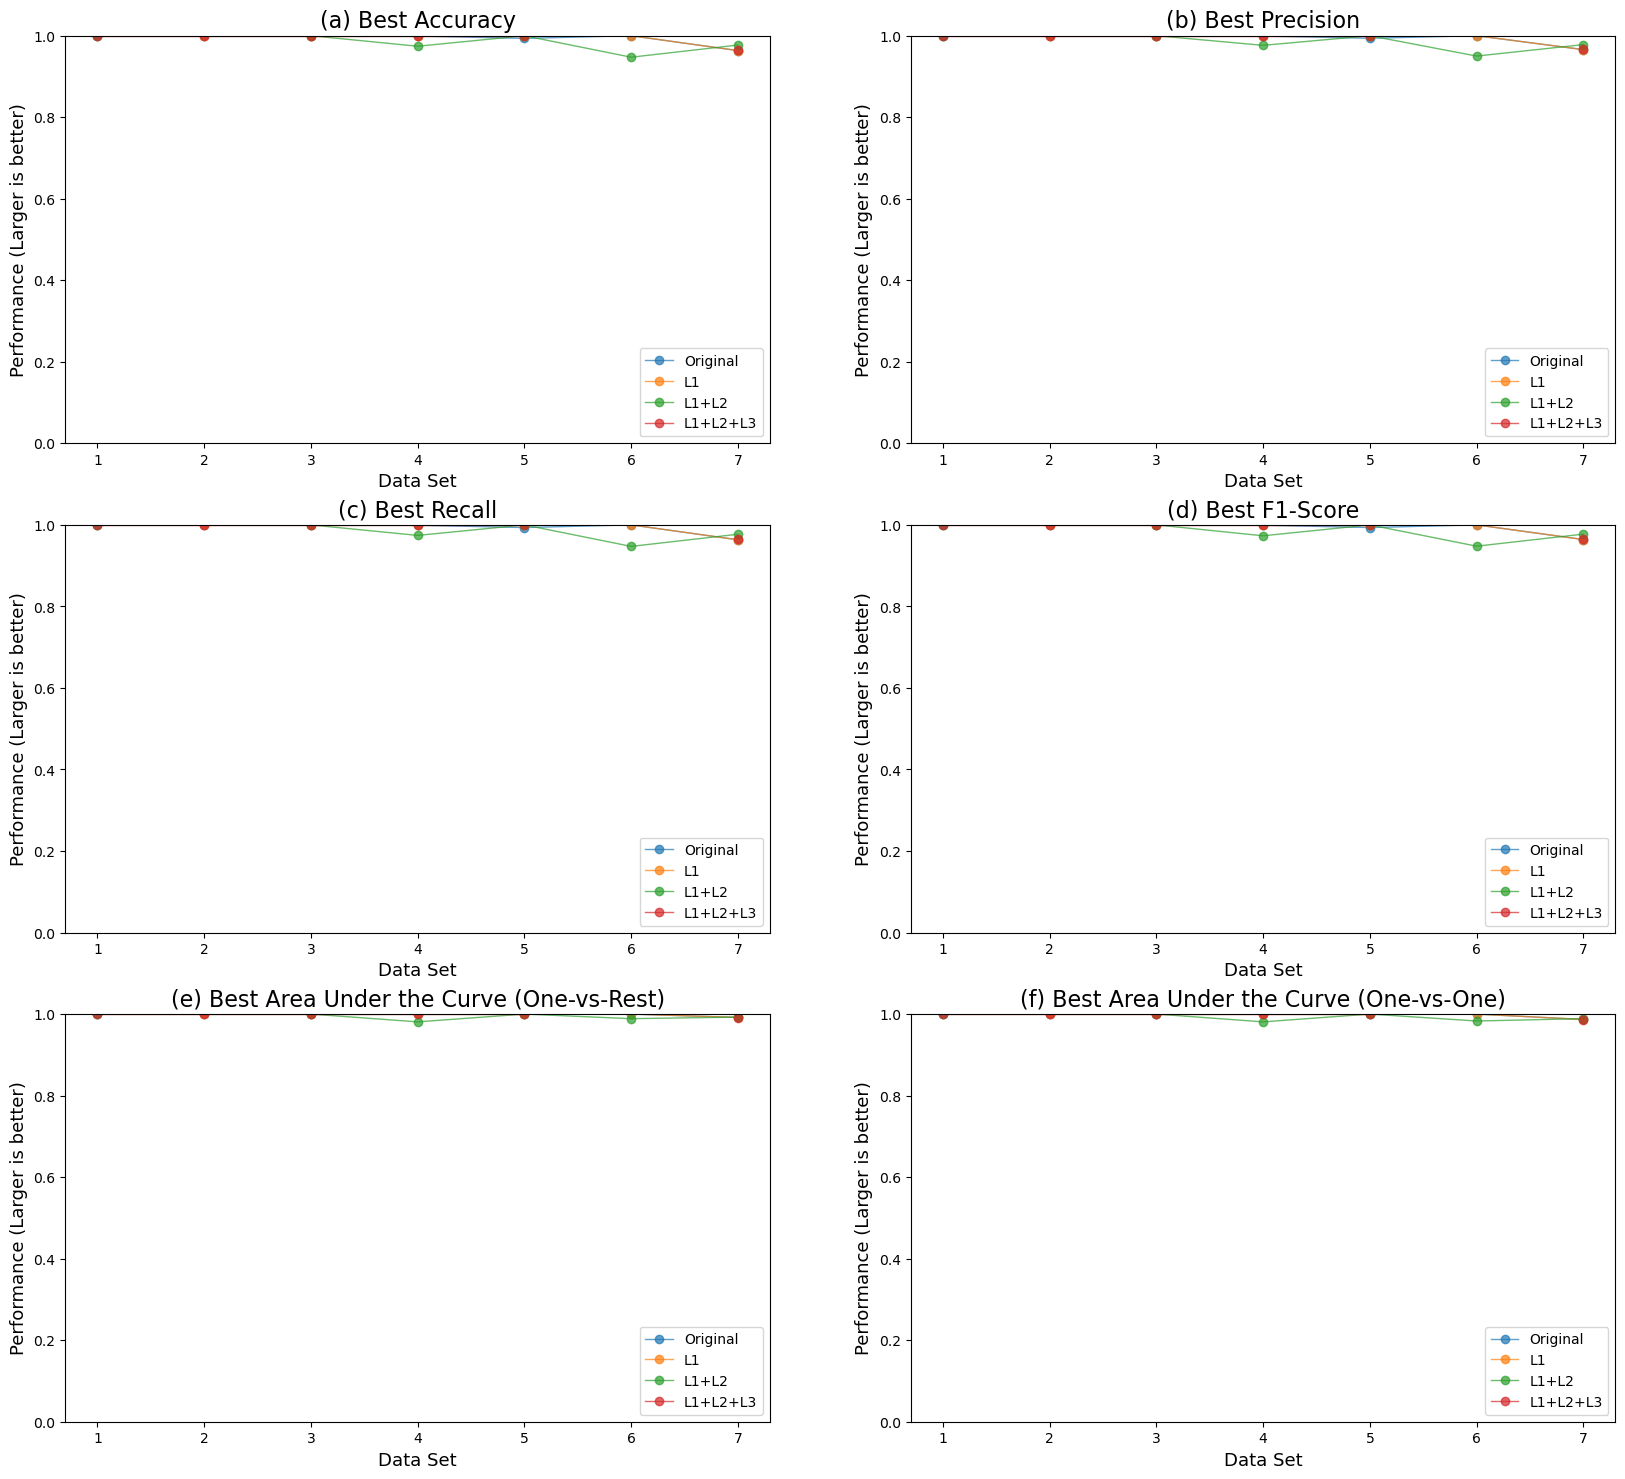

In [7]:
# Plot data set performance comparison
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

files = [];
files_header = [];
files_separator = [];
#files.append("cross_train_accuracy.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
#files.append("cross_train_precision.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
#files.append("cross_train_recall.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
#files.append("cross_train_f1.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
#files.append("cross_train_aucovr.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
#files.append("cross_train_aucovo.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_accuracy.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_precision.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_recall.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_f1.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_aucovr.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C
files.append("cross_test_aucovo.txt"); files_header.append(None); files_separator.append("\t"); # 21A4C

max_k = 10;
max_level = 3;
max_set = 7;
k_array = []
for k in range(0,max_k): k_array.append((2*k)+1); 
s_array = []
for s in range(0,max_set): s_array.append(s+1); 

perf_title = ('(a) Best Accuracy','(b) Best Precision','(c) Best Recall','(d) Best F1-Score','(e) Best Area Under the Curve (One-vs-Rest)','(f) Best Area Under the Curve (One-vs-One)');
label_traintype = ('Original','L1','L1+L2','L1+L2+L3');
plot_row = len(files)//2;
plot_col = 2;
plot_alpha = 0.7;
plot_linewidth = 1;

raw_max = np.zeros((max_set,max_level+1),dtype = np.float64);
figure, axis = plt.subplots(plot_row, plot_col, figsize=(plot_col*10, plot_row*6))
for measure in range(0,len(files)):
    inputfile = files[measure];
    print("Measure:",measure);
    print("Data Source:",inputfile);
    df = pd.read_csv(inputfile, header = files_header[measure], sep = files_separator[measure]);
    raw = df.to_numpy();
    #print(raw)
    for s in range(0,max_set):
        for l in range(0,max_level+1):
            raw_max[s][l] = max(raw[s*(max_level+1)+l]);
#            print(raw[s*(max_level+1)+l])

    for l in range(0,max_level+1):
        axis[measure//2,measure%2].plot(s_array,raw_max.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    #    print(measure//2,measure%2)

#    for d in range(0,max_set): d_array[d] = d+1; 
#        max_test_accuracy[s][l]=max(raw[][l])

#    for l in range(0,max_level+1):
#        axis[measure//2,measure%2].plot(k_array,raw[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    for x in range(0,plot_row):
        for y in range(0,plot_col):
            axis[x,y].set_title(perf_title[x*2+y],fontsize=16)
            axis[x,y].set_xlabel('Data Set',fontsize=13)
            axis[x,y].set_ylabel('Performance (Larger is better)',fontsize=13)
            axis[x,y].set_ylim([0,1])
            axis[x,y].legend(loc='lower right')
figure.savefig("performance-best.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);

print("Task completed.");   


In [6]:
# Plot data set performance comparison

label_traintype = ('Original','L1','L1+L2','L1+L2+L3');
perf_title = ('(a) Best Accuracy','(b) Best Precision','(c) Best Recall','(d) Best F1-Score','(e) Best Area Under the Curve (One-vs-Rest)','(f) Best Area Under the Curve (One-vs-One)','X','X','X');
plot_row = 3;
plot_col = 2;
bar_width = 0.1;

d_array = np.zeros((max_set),dtype = np.intc);
for d in range(0,max_set): d_array[d] = d+1; 
for s in range(0,max_set):
    for l in range(0,max_level+1):
        max_test_accuracy[s][l]=max(global_test_accuracy[s][l])
        max_test_precision[s][l]=max(global_test_precision[s][l])
        max_test_recall[s][l]=max(global_test_recall[s][l])
        max_test_f1[s][l]=max(global_test_f1[s][l])
        max_test_auc[s][l]=max(global_test_auc[s][l])
        max_test_auc2[s][l]=max(global_test_auc2[s][l])

figure, axis = plt.subplots(plot_row, plot_col, figsize=(plot_col*10, plot_row*6))
for l in range(0,max_level+1):
#    axis[0].plot(d_array,max_test_accuracy.T[l],marker='o',label=label_traintype[l])
#    axis[1].plot(d_array,max_test_precision.T[l],marker='o',label=label_traintype[l])
#    axis[2].plot(d_array,max_test_recall.T[l],marker='o',label=label_traintype[l])
#    axis[3].plot(d_array,max_test_f1.T[l],marker='o',label=label_traintype[l])
#    axis[4].plot(d_array,max_test_auc.T[l],marker='o',label=label_traintype[l])
    axis[0,0].plot(d_array,max_test_accuracy.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    axis[0,1].plot(d_array,max_test_precision.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    axis[1,0].plot(d_array,max_test_recall.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    axis[1,1].plot(d_array,max_test_f1.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    axis[2,0].plot(d_array,max_test_auc.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
    axis[2,1].plot(d_array,max_test_auc2.T[l],marker='o',label=label_traintype[l],linewidth=plot_linewidth,alpha=plot_alpha)
#    axis[0,0].scatter(d_array,max_test_accuracy.T[l],marker='o',label=label_traintype[l])
#    axis[0,1].scatter(d_array,max_test_precision.T[l],marker='o',label=label_traintype[l])
#    axis[1,0].scatter(d_array,max_test_recall.T[l],marker='o',label=label_traintype[l])
#    axis[1,1].scatter(d_array,max_test_f1.T[l],marker='o',label=label_traintype[l])
#    axis[2,0].scatter(d_array,max_test_auc.T[l],marker='o',label=label_traintype[l])
#    axis[0,0].bar(d_array*l/5,max_test_accuracy.T[l],width=bar_width,label=label_traintype[l])
#    axis[0,1].bar(d_array*l/5,max_test_precision.T[l],width=bar_width,label=label_traintype[l])
#    axis[1,0].bar(d_array*l/5,max_test_recall.T[l],width=bar_width,label=label_traintype[l])
#    axis[1,1].bar(d_array*l/5,max_test_f1.T[l],width=bar_width,label=label_traintype[l])
#    axis[2,0].bar(d_array*l/5,max_test_auc.T[l],width=bar_width,label=label_traintype[l])   
    for x in range(0,plot_row):
        for y in range(0,plot_col):
            axis[x,y].set_title(perf_title[x*2+y],fontsize=16)
            axis[x,y].set_xlabel('Data Set',fontsize=13)
            axis[x,y].set_ylabel('Performance (Larger is better)',fontsize=13)
            axis[x,y].set_ylim([0,1])
            axis[x,y].legend(loc='lower right')
figure.savefig("performance-best.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);

print("Task completed.");

# Plot data reduction comparison

l_array = np.zeros((max_level),dtype = np.intc);
label_traintype = ('L1','L1+L2','L1+L2+L3');
reduct_title = ('Data Reduction');

scatter_x = traindata[:,0];
scatter_y = traindata[:,1];
scatter_x_min = min(scatter_x);
scatter_x_max = max(scatter_x);
scatter_y_min = min(scatter_y);
scatter_y_max = max(scatter_y);
group = trainlabel;

plt.plot();
plt.plot(l_array,global_reduction[0:3]);
plt.legend(loc='best');
plt.ylim([0,1]);
#plt.savefig(os.path.basename(inputfile)+"-org.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);
plt.show();
plt.savefig("reduction-best.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);

print("Task completed.");



NameError: name 'global_test_accuracy' is not defined

In [ ]:
l_array = np.zeros((max_level),dtype = np.intc);
for l in range(0,max_level): l_array[l] = l+1; 
label_traintype = ('L1','L1+L2','L1+L2+L3');
reduct_title = ('Data Reduction');


#plt.plot();
plt.plot(l_array,global_reduction.T[0:3],marker='o',label=d_array);
plt.legend(loc='lower right')

In [ ]:
dataset
#    [dataset,traintype,k] = perf_train_aucovr[traintype,k] = statistics.mean(scores["train_aucovr"]);
#            global_train_aucovo[dataset,traintype,k] = perf_train_aucovo[traintype,k] = statistics.mean(scores["train_aucovo"]);


In [ ]:
    # Store global
    if (dataset == 0):
        global_fit_time[0] = perf_fit_time;
        global_score_time = perf_score_time;
        global_train_accuracy = perf_train_accuracy;
        global_train_precision = perf_train_precision;
        global_train_recall = perf_train_recall;
        global_train_f1 = perf_train_f1;
        global_train_auc = perf_train_auc;
        global_test_accuracy = perf_test_accuracy;
        global_test_precision = perf_test_precision;
        global_test_recall = perf_test_recall;
        global_test_f1 = perf_test_f1;
        global_test_auc = perf_test_auc;
    else:
        global_fit_time = np.concatenate((global_fit_time,perf_fit_time),axis=0);
        global_score_time = np.concatenate((global_score_time,perf_score_time),axis=0);
        global_train_accuracy = np.concatenate((global_train_accuracy,perf_train_accuracy),axis=0);
        global_train_precision = np.concatenate((global_train_precision,perf_train_precision),axis=0);
        global_train_recall = np.concatenate((global_train_recall,perf_train_recall),axis=0);
        global_train_f1 = np.concatenate((global_train_f1,perf_train_f1),axis=0);
        global_train_auc = np.concatenate((global_train_auc,perf_train_auc),axis=0);
        global_test_accuracy = np.concatenate((global_test_accuracy,perf_test_accuracy),axis=0);
        global_test_precision = np.concatenate((global_test_precision,perf_test_precision),axis=0);
        global_test_recall = np.concatenate((global_test_recall,perf_test_recall),axis=0);
        global_test_f1 = np.concatenate((global_test_f1,perf_test_f1),axis=0);
        global_test_auc = np.concatenate((global_test_auc,perf_test_auc),axis=0);


In [ ]:
l_array,global_reduction

In [ ]:
    figure, axis = plt.subplots(4, 2, figsize=(10, 20))
#    figure.set_size_inches(10, 10)
#    axis.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    for row in range(0,dataset//2):
        for col in range(0,2):
            axis[row,col].plot(k_array,perf_test_accuracy[0],marker='o',label='Original')
            axis[row,col].plot(k_array,perf_test_accuracy[1],marker='o',label='L1')
            axis[row,col].plot(k_array,perf_test_accuracy[2],marker='o',label='L1+L2')
            axis[row,col].plot(k_array,perf_test_accuracy[3],marker='o',label='L1+L2+L3')
            axis[row,col].set_title(str(row*dataset//2+col+1))
        #    axis[dataset,0].xlabel('k')
        #    axis[dataset,0].ylabel('AUC')
            #plt.xlim(xmin = 0, xmax = 10)
        #    axis[dataset,0].ylim(ymin = 0, ymax = 1)
        #    axis[dataset,0].xticks(k_array,k_array)
            axis[row,col].legend(loc='best')
        #    plt.savefig(os.path.basename(inputfile)+"-auc.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);
            figure.savefig(str(dataset+1).zfill(2)+"-auc.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);
        #    figure.show()                


In [ ]:
#del global_fit_time\
global_fit_time = [] * 10
#global_fit_time = np.concatenate((global_fit_time,perf_fit_time),axis=0);
global_fit_time

In [ ]:
sklearn.metrics.SCORERS.keys

In [ ]:
del best_fit_time
best_fit_time = np.zeros((0,max_measure),dtype = np.float64);
print(perf_fit_time[traintype]);
best_fit_time = perf_fit_time[traintype];
np.concatenate((best_fit_time,perf_fit_time[traintype]),axis=0);
print(best_fit_time)

In [ ]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
plt.scatter([0] * max_measure,perf_test_accuracy[0],marker='.',s=5,label='Original')
plt.scatter([reduction[0]/reduction[0]] * max_measure,perf_test_accuracy[1],marker='.',s=5,label='L1')
plt.scatter([reduction[1]/reduction[0]] * max_measure,perf_test_accuracy[2],marker='.',s=5,label='L1+L2')
plt.scatter([reduction[2]/reduction[0]] * max_measure,perf_test_accuracy[3],marker='.',s=5,label='L1+L2+L3')
plt.title('AUC Comparison')
plt.xlabel('k')
plt.ylabel('AUC')
#plt.xlim(xmin = 0, xmax = 10)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(loc='best')
plt.savefig(os.path.basename(inputfile)+"-auc.pdf", format="pdf", dpi=None, facecolor="w", edgecolor="w", orientation="portrait", transparent=True, bbox_inches="tight", pad_inches=0.1, metadata=None);
plt.show()                


# KD-Tree Generating L1, L2, L3

In [ ]:
# https://scikit-learn.org/stable/modules/neighbors.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
#from sklearn.neighbors import KDTree
# print(sorted(KDTree.valid_metrics))
#tree = KDTree(traindata, leaf_size=2)

# Split dataset into subsets based on class value
datasets = {}
if (files_label == [-1]):
    by_class = df.groupby(df.shape[1]-1)
else:
    by_class = df.groupby(files_label)
    
for groups, data in by_class:
    datasets[groups] = data

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
for x in range(0,groups):
    neigh.fit(datasets[x])
    for y in range(0,groups):
        print(neigh.kneighbors(datasets[y].values[0].reshape(1,-1), 2, return_distance=False))

In [ ]:
len(reduction_class_org)

In [ ]:
scores["train_aucovo"]

In [ ]:
# Generate synthetic data set #1
import numpy as np
import math
import matplotlib.pyplot as plt

max = 300;
y1 = np.zeros((max),np.float64)
y2 = np.zeros((max),np.float64)
y3 = np.zeros((max),np.float64)
# y4 = np.zeros((max),np.float64)
# y5 = np.zeros((max),np.float64)
for x in range(0,max):
    y1[x] = math.sin(x/10)+np.random.random_sample()*3
    y2[x] = math.sin(x/10)+3+np.random.random_sample()*3
    y3[x] = math.sin(x/10)+6+np.random.random_sample()*3
#     y4[x] = math.sin(x/10)+6+np.random.random_sample()+np.random.random_sample()
#     y5[x] = math.sin(x/10)+8+np.random.random_sample()+np.random.random_sample()
fig = plt.figure(figsize=(20,10));
xx = np.array(range(0,max));
plt.plot(xx,y1,'.',markersize=1);
plt.plot(xx,y2,'.',markersize=1);
plt.plot(xx,y3,'.',markersize=1);

# plt.plot(range(0,max),y4,'.',markersize=3)
# plt.plot(range(0,max),y5,'.',markersize=3)
#z = np.vstack((x,y))
# with open("sine.txt", "ab") as file:
#     np.savetxt(file, x.reshape(1,max_level), delimiter='\t', fmt='%1.4f')        


In [ ]:
#a = raw[:,21]
enc = OneHotEncoder();
OneHotEncoder(categories='auto', drop=None, sparse=True, handle_unknown='error')
enc.fit(raw[:,21].reshape(-1, 1))
#print(enc.categories_)
enc.fit_transform(raw[:,21].reshape(-1,1)).toarray()

In [ ]:
perf_train_aucovr

In [ ]:
d_array,max(global_test_accuracy[1][0])

In [ ]:
        dflist = df.dtypes.tolist()
        for i in range(0,len(dflist)):
            if(dflist[i]=="object"):
                print(i,"E ",end="",sep="");
                # creating instance of one-hot-encoder
                enc = OneHotEncoder(handle_unknown='ignore')
                # passing bridge-types-cat column (label encoded values of bridge_types)
                OneHotEncoder(categories='auto', drop=True, sparse=True, handle_unknown='error')
                #print(enc.categories_)
                encode_temp = enc.fit_transform(raw[:,i].reshape(-1,1)).toarray()
                print(encode_temp)
            else:
                print(i," ",end="",sep="");
        print(") (OneHotEncoding)");
print(encode_temp)

In [ ]:
reduction

In [ ]:
    inputfile = files[dataset];
    print("Dataset:",dataset);
    print("Data Source:",inputfile);
    if (inputfile[-2:] == "gz"):
        df = pd.read_csv(inputfile, header = files_header[dataset], sep = files_separator[dataset], compression="gzip");
    elif (inputfile[-3:] == ".zip"):
        df = pd.read_csv(inputfile, header = files_header[dataset], sep = files_separator[dataset], compression="zip");
    elif (inputfile[-4:] == ".xls") or (inputfile[-4:] == "xlsx"):
        df = pd.read_excel(inputfile, header = files_header[dataset]);      
    else:
        df = pd.read_csv(inputfile, header = files_header[dataset], sep = files_separator[dataset]);
    raw = df.to_numpy();
  

In [ ]:
raw

In [ ]:
pd.read_csv(inputfile, header = 0, sep = files_separator[dataset])

In [ ]:
inputfile

In [ ]:
figure.ylim(ymin = 0, ymax = 1)

In [ ]:
import numpy as np
d = np.zeros((10),dtype = np.intc);
d

In [ ]:
global_fit_time[dataset,traintype,k] = perf_fit_time[traintype,k] = statistics.mean(scores["fit_time"]);

In [ ]:
np.sort(np.unique(group))

In [ ]:
np.unique(group)